# The UKF exposed: How it works, when it works and when it's better to sample

Sebastian Bitzer (sebastian.bitzer@tu-dresden.de)

## Introduction

Probabilistic filters infer the likely positions of a dynamically changing, but unobserved hidden state given some noisy observations and a probabilistic model which defines how the hidden state changes and relates to observations. The best known of these filters is the Kalman filter which is defined for linear models with Gaussian noise where it is exact, i.e., if the observations are really generated by the assumed Gaussian linear model, the Kalman filter computes the true posterior density over the hidden state. For nonlinear models, even under the assumption of Gaussian generative noise, the true posterior over the hidden state becomes non-Gaussian and probably multimodal. Yet, you can try to approximate the true posterior with, for example, a Gaussian to still apply the Kalman filter framework in principle. One such approach is the Extended Kalman Filter (EKF) where the nonlinear model functions are locally linearised to be able to still apply the standard Kalman filter updates locally in each step. This has, however, been shown to be an inaccurate approximation for many nonlinear models.

Another approach to probabilistic filtering is to sample from the state distribution and then to propagate the samples through the model functions to approximate the resulting distributions without making any assumptions of their form. This is known under the name of sequential monte carlo or particle filtering and has become a very popular method. However, it requires considerable amount of computation time, if approximations are to be made exact and the hidden state has many dimensions (the higher the dimension, the more samples you need to approximate the underlying distribution reliably).

To overcome the limitations of the EKF without spending the resources necessary for a particle filter the Unscented Kalman Filter (UKF) has been proposed. The UKF represents a state distribution with a small set of very special samples which is called the *sigma points*. These sigma points are propagated through the model functions and then are used to approximate the predictive distributions of the model which are needed to apply standard Kalman filter updates. The trick with the sigma points is that they are chosen such that a very small number of them leads to a better approximation of the predictive distributions than what would be achieved with the linearisation of the EKF.

Many descriptions of the UKF provide instructions for generating a standard set of sigma points given some parameter values, but lack an explanation for what the parameters actually do. This is because the parameter values which lead to good approximations depend on the particular assumed generative model and there are no simple analytic guidelines which would relate parameter values to the accuracy of the approximation for any given generative model. Here, I investigate different algorithms which generate sigma points and try to explain why one leads to good approximations under the usual assumption of Gaussian densities while another doesn't.

## The Theory of the Unscented Transform

The core approximation that the UKF uses is the Unscented Transform (UT). Apparently the UT has been developed by [Uhlmann](http://bengal.missouri.edu/~uhlmannj/public_html/) & [Julier](http://www0.cs.ucl.ac.uk/people/S.Julier.html) in the 1990s, but most of the material used here comes from their [2004 review](http://dx.doi.org/10.1109/JPROC.2003.823141). The mindset behind the UT is clearly an engineering one where computational efficiency is traded off against the accuracy of the solution. Although a similar tradeoff may be achieved in a particle filter by varying the number of used particles, the UT tries to improve upon the efficiency of random particles by choosing a minimum number of particular particles, the sigma points, that can be analytically shown to guarantee a desired level of accuracy. 

In the following I will provide the theoretical background for the UT and will define four increasingly complex instantiations of UT (sigma point sets) as I go along. I will also point out a gap in the argument which supposedly guarantees a desired level of accuracy of the UT.

### Problem definition

I define a multidimensional random variable ${\bf r} \in {\mathcal R}^D$ (a vector of random variables) that is transformed through some nonlinear function ${\bf h}({\bf r}) = {\bf o}$ which makes it to the transformed random variable ${\bf o} \in {\mathcal R}^d$. Knowing something about the probability density $p({\bf r})$ I would then like to approximate the transformed density $p({\bf o})$. To be precise, I only want to approximate the mean $\bar{\bf o}$ and covariance $\Sigma_o$, because these are the only two entities that I need in a Kalman filter. [Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) have shown that the more I know about $p({\bf r})$ the better my approximation of $\bar{\bf o}$ and $\Sigma_o$ will be.

Notice that, just because I concentrate on mean and covariance, I do not need to assume a Gaussian approximation in the UT. For example, assume that $\bf r$ and $\bf o$ live in the same space, I could then generate sigma points from a given mean and covariance of $\bf r$, project them through $\bf h$, estimate the resulting mean and covariance and then generate sigma points from the estimated mean and covariance, all without making any more assumptions about the underlying distributions. Practically, however, there is no advantage of leaving the particular approximation unspecified, because the accuracy of the approximation of mean and covariance of $\bf o$ also depends on the higher moments of $\bf r$, as I reiterate from [Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) next.

### Taylor series approximation of  mean and covariance

I can represent the transformation function $\bf h$ with a [Taylor series](https://en.wikipedia.org/wiki/Taylor_series) around the mean of $p({\bf r})$, ${\bf \bar{r}}$. I choose the mean, because it is one of the most informative points about the density $p({\bf r})$, and, more importantly, this allows me to formulate the approximation in terms of [central moments](https://en.wikipedia.org/wiki/Moment_%28mathematics%29) of the distribution $p({\bf r})$.

$$
{\bf o} = {\bf h}({\bf r}) = {\bf h}({\bf \bar{r}}) + {\bf D}_{\bf e}{\bf h} + \frac{1}{2!}{\bf D}_{\bf e}^2{\bf h} + \frac{1}{3!}{\bf D}_{\bf e}^3{\bf h} + \dots
$$

where ${\bf e} = {\bf r} - {\bf \bar{r}}$ and I have copied the notation of [Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) for [multidimensional Taylor series](https://en.wikipedia.org/wiki/Taylor_series#Taylor_series_in_several_variables) in which ${\bf D}_{\bf e}^i{\bf h}$ is shorthand for the higher order polynomial terms including partial derivatives:

$$
{\bf D}_{\bf e}^i{\bf h} = \left.\left( \sum_{j=1}^D e_j \frac{\partial}{\partial r_j} \right)^i {\bf h}({\bf r})\right|_{{\bf r}=\bar{{\bf r}}}
$$

Notice how this translates into other forms to write these terms, e.g., for the second order term:

$$
{\bf D}_{\bf e}^2{\bf h} = \left.\left( \sum_{j=1}^D e_j \left. \frac{\partial}{\partial r_j} \right)^2 {\bf h}({\bf r})\right|_{{\bf r}=\bar{{\bf r}}} = \sum_{j=1}^D\sum_{k=1}^D e_j e_k \frac{\partial^2}{\partial r_j \partial r_k} {\bf h}({\bf r}) \right|_{{\bf r}=\bar{{\bf r}}} 
$$

To get the mean of $p({\bf o})$ I can simply apply the corresponding expectation to the above formula such that

$$
{\bf \bar{o}} = E[{\bf o}] = E[{\bf h}({\bf \bar{r}})] + E[{\bf D}_{\bf e}{\bf h}] + \frac{1}{2!}E[{\bf D}_{\bf e}^2{\bf h}] + \dots
$$

where the expectation is over the original random variable $\bf r$. If I want to approximate the mean, I can cut the higher order terms of the Taylor series as usual. For example, you can linearise which gives

$$
\bar{\bf o} \approx {\bf h}({\bf \bar{r}}) + \sum_{j=1}^D E[e_j]\frac{\partial}{\partial r_j}\left. {\bf h}({\bf r})\right|_{{\bf r}=\bar{\bf r}} = {\bf h}(\bar{\bf r}),
$$

because the first [central moments](https://en.wikipedia.org/wiki/Moment_%28mathematics%29) $E[e_j]$ are 0. This is interesting, because it means that the gradient of ${\bf h}$ is irrelevant for determining the mean $\bar{{\bf o}}$. Obviously, higher order central moments such as the covariances need not be 0. Therefore, the quality of the approximation depends on how much the higher order moments contribute to the estimated mean $\bar{\bf o}$ which also depends on the corresponding partial derivatives of the nonlinear transformation ${\bf h}({\bf r})$ around the mean $\bar{\bf r}$. For example, when the covariance between two of the random variables, $E[e_je_k]$, increases, the linear approximation of the mean $\bar{\bf o}$ above should get worse. Note that $j$ could be equal to $k$, i.e., the more uncertainty about a random variable $r_j$ there is, the worse is the approximation of $\bar{\bf o}$. Similarly, if the mean $\bar{\bf r}$ moves into a region where the local curvature of ${\bf h}$ increases, the approximation gets worse. Similar arguments hold for higher order moments (skewness, kurtosis) and higher order partial derivatives (whatever you want to call them - I don't have intuitions about them).

The covariance of $\bf o$ is

$$
\Sigma_o = E\left[ ({\bf o} - \bar{\bf o})({\bf o} - \bar{\bf o})^T \right] = \sum_{i_1=1}^\infty \sum_{i_2=1}^\infty \frac{E\left[ {\bf D}_{\bf e}^{i_1}{\bf h}({\bf D}_{\bf e}^{i_2}{\bf h})^T  \right] - E[{\bf D}_{\bf e}^{i_1}{\bf h}]E[{\bf D}_{\bf e}^{i_2}{\bf h}]^T}{i_1!i_2!}
$$

which simplifies to

$$
\Sigma_o \approx E\left[ {\bf D}_{\bf e}{\bf h}({\bf D}_{\bf e}{\bf h})^T  \right] = {\bf J}(\bar{\bf r})\Sigma_r{\bf J}^T(\bar{\bf r})
$$

for a linear approximation where ${\bf J}(\bar{\bf r})$ is the [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of $\bf h$ evaluated at $\bar{\bf r}$. The covariance, therefore, depends on the gradients of $\bf h$ as well as the covariance of $\bf r$ plus all the higher order terms. [Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) further note that for symmetric distributions all terms where $i_1 + i_2$ is odd are 0, because these terms contain odd central moments which are 0 for symmetric distributions. In any case, the general formula shows that for an approximation of the covariance of $\bf o$ with order $m$ where $\max(i_1,i_2)=m$ you need to know central moments of the distribution of $\bf r$ whose order is larger than $m$.

The point of the excercise is that we now understand better why simple linearisation, as it is done in the Extended Kalman Filter, fails in many situations, especially, when uncertainty is high which leads to bad approximation of the mean $\bar{\bf o}$. It is also clear now that it is tricky to make better than linear approximations of the covariance $\Sigma_o$, because for that we immediately need to know about high order ($\geq 3$) central moments of $p({\bf r})$ and high order partial derivatives of $\bf h$. In principle, the unscented transform is designed to at least capture a few more higher order moments than a linearisation would do, as I describe next.

### Is it really enough to capture as many as possible moments?

The main idea of the UT is to select an as small as possible set of _sigma points_ ${\bf S} = [{\bf s}_1, \dots, {\bf s}_N]$, which represents as many as possible moments of $p({\bf r})$. Then, to project the sigma points through $\bf h$ and approximate the transformed mean $\bar{\bf o}$ and covariance $\Sigma_o$ with the mean $\hat{\bf o}$ and covariance $\widehat{\Sigma}_o$ of the sigma points. The rest is hope, because I have not seen an analytical argument which would, for example, guarantee that this procedure actually corresponds to using the higher order terms of the Taylor series defined above. The Taylor series formulation just provides an intuitive motivation for why I should want that the used sigma points capture many higher moments of $p({\bf r})$. Although [Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) state that

>  Any set of sigma points that encodes the mean and covariance correctly, including the set in (11), calculates the projected mean and covariance correctly to the second order (see Appendixes I and II).

they don't actually show this in the referred appendices. I miss the connection from projected sigma points to higher order partial derivatives of $\bf h$ that occur in the higher order Taylor series terms. Do I overlook some basic property about points projected through a nonlinear function that would guarantee that? If yes, great! If not, we're back to hope. I have also not seen a numerical check of Julier and Uhlmann's above statement where somebody would have to have gone through computing 4th order partial derivatives and moments to analytically approximate the covariance $\Sigma_o$ and check whether the UT approximation is equally close to the true $\Sigma_o$ (perhaps approximated by a large number of random samples). Also, which criterion would you use to say that the approximation from the UT is at least as good as the 2nd order Taylor series approximation? This is all more practical to do for the approximated mean $\hat{\bf o}$, but I defer doing that to some unspecified point in the future. So, for now I'm going to believe Julier and Uhlmann and follow them in the hope that I only need to care about how many higher moments a specific set of sigma points captures and the rest is taken care of by simply projecting the sigma points through the nonlinear function $\bf h$.

### What it means to capture a moment
Formally, _capturing_ the moment of a distribution $p({\bf r})$ with a set of sigma points ${\bf S} = [{\bf s}_1, \dots, {\bf s}_N]$ means that I can reconstruct the value of the moment from the sigma points. In general, I define an arbitrary moment of a $D$-dimensional variable ${\bf r} = [r_1, \dots, r_D]^T$ as 

$$
m(r_{i_1}, \dots, r_{i_M}) = E[r_{i_1} \dots r_{i_M}] = \int p({\bf r})r_{i_1} \dots r_{i_M} d{\bf r}
$$

where $M$ is the order of the moment and the indices $i_1, \dots, i_M$ select the particular elements of $\bf r$ that contribute to the moment. For example, the third moment in the second element of $\bf r$, i.e., $m(r_2^3)$ is defined as $i_1=i_2=i_3=2$. To use central moments I replace $\bf r$ with ${\bf e} = {\bf r} - E[{\bf r}] = {\bf r} - \bar{\bf r}$. For example, the covariance between $r_1$ and $r_2$ is defined as $\Sigma_{12} = m(e_1, e_2)$.

In the unscented transform [Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) suggested that moments should be reconstructed from sigma points using

$$
m(r_{i_1}, \dots, r_{i_M}) \approx \hat{m}(r_{i_1}, \dots, r_{i_M}) = \sum_{n=1}^N w_n s_{i_1n} \dots s_{i_Mn}
$$

where $s_{i_1n}$ is the $i_1$-th element of the $n$-th sample and $w_n$ is a weight associated with the $n$-th sigma point. This is a very general formulation which also includes the case in which you approximate the moment of the underlying distribution with the corresponding moment of the set of sigma points. For example, the sample covariance simply is

$$
\widehat{\Sigma}_{i_1i_2} = \hat{m}(e_{i_1}, e_{i_2}) = \frac{1}{N}\sum_{n=1}^N \hat{e}_{i_1n}\hat{e}_{i_2n}
$$

where $w_n = 1/N$ and $\hat{e}_{in} = s_{in} - \bar{r}_i$.

### Capturing mean and covariance (min set)

The whole point of the UT is to construct sigma point sets with as few as possible sigma points which still capture as many as possible moments. By trying to capture higher moments I may get an approximation that is better than the linear one used by the EKF and by using as few as possible sigma points I may be computationally more efficient than a particle filter. So how can I make sigma point sets which capture the _given_ moments of a distribution?

In the context of Kalman filters I mostly concentrate on mean and covariance. So let's start with these. Capturing the mean alone is super easy. I only need one sigma point for that which is 

$$
{\bf s}_0 = \bar{\bf r}
$$

with $w_0 = 1$. 

For the covariance of a $D$-dimensional random variable I need at least $D$ sigma points. To see that I need some linear algebra and I need to remember that 

$$
\widehat{\Sigma}_{ij} = \frac{1}{N}\sum_{n=1}^N \hat{e}_{in} \hat{e}_{jn} = \frac{1}{N}\left[\sum_{n=1}^N \hat{\bf e}_n\hat{\bf e}_n^T\right]_{ij}.
$$

If I let $\widehat{\bf E} = [\hat{\bf e}_1, \dots, \hat{\bf e}_N]$,

$$
\widehat{\Sigma} = \frac{1}{N}\sum_{n=1}^N \hat{\bf e}_n\hat{\bf e}_n^T = \frac{1}{N}\widehat{\bf E}\widehat{\bf E}^T.
$$

I want that $\widehat{\Sigma} = \Sigma$ where $\Sigma$ is the given covariance matrix which, as I know, is positive definite. This means that I can decompose $\Sigma$ using the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) such that

$$
\Sigma = {\bf L}{\bf L}^T
$$

where ${\bf L} = [{\bf l}_1, \dots, {\bf l}_D] \in \mathcal{R}^{D\times D}$ is a lower triangular matrix. Well, this has the same form as $\widehat{\Sigma}$ above. So I can set $\hat{\bf e}_i = \sqrt{D}{\bf l}_i$ to make $\widehat{\Sigma} = \Sigma$. Consequently, I need at least $N=D$ sigma points which need to be

$$
{\bf s}_n = \bar{\bf r} + \sqrt{D}{\bf l}_n \qquad n \in {1, \dots, D}.
$$

By construction, with $w_n = 1/D$, these sigma points, thus, capture the covariance $\Sigma$. At the same time the construction shows that $D$ is the samllest number of sigma points that can capture all components of the covariance. Together with the mean I therefore need at least $D+1$ sigma points to capture the first two moments of $p({\bf r})$ resulting in the following set of sigma points which I call the _min set_:

\begin{align}
{\bf s}_0 &= \bar{\bf r}\\
{\bf s}_n &= \bar{\bf r} + \sqrt{D}{\bf l}_n \qquad n \in {1, \dots, D}\\
w_0^m &= 1 \quad w_n^m = 0\\
w_0^c &= 0 \quad w_n^c = \frac{1}{D}
\end{align}

where I had to use different weights for reconstructing the mean ($w^m$) and reconstructing the covariance ($w^c$). I can use a common set of weights with a symmetric set of sigma points, as described next.

### Capturing symmetric distributions (base set)

For symmetric distributions there is a very simple way to capture many higher moments, because all odd central moments of symmetric distributions are 0, i.e.,

$$
m(e_{i_1}, \dots, e_{i_M}) = 0
$$

when $M$ is odd. This is because there is an equal amount of mass on the left and on the right of the mean which cancels when you integrate over all values. I can capture this property by choosing a symmetric set of sigma points. Of course, I don't want to loose the representation of the covariance which is why I choose the following set of sigma points which I call the _base set_:

\begin{align}
{\bf s}_n &= \bar{\bf r} + \sqrt{D}{\bf l}_n \quad n \in {1, \dots, D}\\
{\bf s}_{n+D} &= \bar{\bf r} - \sqrt{D}{\bf l}_n\\
w_j &= \frac{1}{2D} = \frac{1}{N} \quad j\in 1, \dots, N
\end{align}

When I subtract the mean from these sigma points and sum over them, I get 0 as long as the sign is preserved, i.e.,

$$
\hat{m}(\hat{e}_{i_1}, \dots, \hat{e}_{i_M}) = 0
$$

when $M$ is odd. Also, the symmetry means that sigma points ${\bf s}_1, \dots, {\bf s}_{2D}$ average to $\bar{\bf r}$ which is the same as the weighted sum of sigma points with $w_j = 1/2D$.

Note that this set of sigma points, when embedded in a [Gaussian filter](https://doi.org/10.1109/TSP.2006.875389), also implements the [Cubature Kalman Filter](https://doi.org/10.1109/TAC.2009.2019800) as shown by [Simo Särkkä](http://users.aalto.fi/~ssarkka/) in his book on [Bayesian Filtering and Smooting](http://www.cambridge.org/sarkka) (also available as pdf on his website, see chapter 6).

### Capturing higher order moments (Gauss set)

It is really tedious to think about higher moments of arbitrary multivariate distributions. Therefore, I will stick with a distribution that is simple and well-known: the [multivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). For the Gaussian, mean and covariance are the [sufficient statistic](https://en.wikipedia.org/wiki/Sufficient_statistic) of the distribution, i.e., these parameters are sufficient to completely specify the distribution. As a result, higher (central) moments of the distribution can be formulated in terms of the covariances. A particular formula is defined by [Isserli's theorem](https://en.wikipedia.org/wiki/Isserlis'_theorem) which, for 4th order moments (aka. [kurtosis](https://en.wikipedia.org/wiki/Kurtosis)), prescribes

$$
m(e_{i_1}, e_{i_2}, e_{i_3}, e_{i_4}) = \Sigma_{i_1i_2}\Sigma_{i_3i_4} + \Sigma_{i_1i_3}\Sigma_{i_2i_4} + \Sigma_{i_1i_4}\Sigma_{i_2i_3}.
$$

Hang on. If the mean and covariance is everything there is to know about the Gaussian, why should I care about capturing higher moments, if I approximate all densities in my model with Gaussians? I gave an intuitive reason when discussing the Taylor approximation above. The problem is that the nonlinear function may add strange distortions to the probability distribution and by trying to capture as many as possible properties of the distribution explicitly in the sigma points we may get a better approximation of the introduced distortions. Below I will test this assumption numerically by comparing a set of sigma points that was specified to capture higher order moments with the base set and a set of sigma points that was randomly chosen.

[Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) presented a set of sigma points which can capture 4th order moments, but the set consists of $2D^2 + 1$ sigma points and is quite complicated to construct. As an alternative they extended the base set above and introduced additional parameters which may be tuned such that the difference in 4th (and perhaps higher) order moments is minimised.

__Partially capturing kurtosis.__ The equation for the 4th Gaussian moments above suggests a considerable simplification when the Gaussian is isotropic, i.e., $\Sigma$ is diagonal. Then, the only nonzero moments are (the order of the arguments of $m$ doesn't matter):

$$
m(e_{i_1}, e_{i_1}, e_{i_2}, e_{i_2}) = \Sigma_{i_1i_1}\Sigma_{i_2i_2}
$$

and 

$$
m(e_i, e_i, e_i, e_i) = 3\Sigma_{ii}^2.
$$

In comparison, the sample moments $\hat{m}$ for the base set and diagonal covariance are

$$
\hat{m}(\hat{e}_{i_1}, \hat{e}_{i_2}, \hat{e}_{i_3}, \hat{e}_{i_4}) = \sum_{n=1}^{2D}w_n a_n^4 l_{i_1n}l_{i_2n}l_{i_3n}l_{i_4n} = \left\{ 
\begin{array}{cl} 
D\Sigma_{ii}^2 & i=i_1=i_2=i_3=i_4\\
0 & \mathrm{else}
\end{array}\right.
$$

where $w_n = 1/2D$ and $a_n = \sqrt{D}$. Because I want to keep the construction of sigma points from the square root of $\Sigma$ ($\bf L$), I cannot capture $m(e_{i_1}^2, e_{i_2}^2)$, but [Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) came up with a way to capture $m(e_i^4)$ without affecting the reconstructions for mean and covariance. They did this by introducing one extra sigma point ${\bf s}_0$ and adjusting sigma points ($a_n$) and weights $w_n$ resulting in what I call the _Gauss set_:

\begin{align}
\kappa &\in \mathcal{R}^+\\
{\bf s}_0 &= \bar{\bf r}\\
{\bf s}_n &= \bar{\bf r} + a_n{\bf l}_n\\
{\bf s}_{n+D} &= \bar{\bf r} - a_n{\bf l}_n \qquad n \in 1,\dots,D\\
w_0 &= 1 - \frac{D}{\kappa}\\
w_j &= \frac{1 - w_0}{2D} = \frac{1}{2\kappa} \qquad j\in 1,\dots, 2D\\
a_n &= \sqrt{\frac{D}{1 - w_0}} = \sqrt{\kappa}.
\end{align}

There are several things to recognise: i) The mean is still captured, but this is not done by simply averaging the sigma points. Instead, ${\bf s}_0$, which is the actual mean, contributes with weight $w_0$ to the computation of the mean whereas all other sigma points contribute $1-w_0 = D/\kappa$. The new parameter $\kappa$, therefore, controls this new mixture of sigma points, but note that $w_0$ becomes negative for $\kappa < D$. This mixing is obviously unimportant as long as we just consider capturing the mean of $p({\bf r})$, but it may have an effect when we estimate $\hat{\bf o}$ after nonlinear transformation of the sigma points. ii) The covariance is still captured, because ${\bf s}_0 - \bar{\bf r} = {\bf 0}$ and the contribution of $w_0$ cancels between $w_n$ and $a_n$. Again, however, notice that $a_n$ grew with $D$ in the base set whereas here it is fixed to $\sqrt{\kappa}$. This may have very different impacts after nonlinear transformation. iii) I can easily recover the base set by setting $\kappa = D$. Finally, iv) I see that some of the 4th moments are captured for $\kappa=3$, i.e., $\hat{m}(\hat{e}_i^4) = 3\Sigma_{ii}^2$. 

In summary, this new set of sigma points introduced some changes to the construction of the sigma points which on their own may already have positive effects on the estimation of mean and covariance after nonlinear transformation. Intuitively, introducing an explicit sigma point for the mean and weighting it strongly after nonlinear transformation may have a stabilizing effect on the estimate of the mean. Similarly, fixing the dispersion of sigma points (irrespective of scaling due to the covariances) instead of using greater dispersion in higher dimensions may also result in more stable results, because the nonlinearity is approximated by the sigma points more locally, i.e., only in the area prescribed by the covariance. Whether the kurtosis is captured or not, may then not be that important anymore. This is underlined by the fact that anyway most 4th-order moments of the Gaussian are not captured by this sigma point set.

### Nonnegative weights (mean set)

As I mentioned above, the Gauss set uses negative weight $w_0$ for $\kappa < D$. This negative weight can lead to instabilities when estimating the transformed covariance matrix $\Sigma_o$, i.e., $\Sigma_o$ may then not be positive definite anymore (as seen in my results below). I can prevent negative $w_0$ by increasing $\kappa$ with $D$, as it is already the case for the base set where $\kappa = D$ and the 0th sigma point ${\bf s}_0$ for the mean is removed. It is not necessary, however, to remove the focus on the mean from the sigma point set. Instead, I can use the weight $w_0$ as parameter and constrain it to be in $[0, 1)$ which gives the following sigma point set derived from the Gauss set:

\begin{align}
w_0 &\in [0, 1)\\
{\bf s}_0 &= \bar{\bf r}\\
{\bf s}_n &= \bar{\bf r} + \sqrt{\frac{D}{1 - w_0}}{\bf l}_n\\
{\bf s}_{n+D} &= \bar{\bf r} - \sqrt{\frac{D}{1 - w_0}}{\bf l}_n \qquad n \in 1,\dots,D\\
w_j &= \frac{1 - w_0}{2D} \qquad j\in 1,\dots, 2D.\\
\end{align}

This sigma point set, which I call the _mean set_, ensures that all weights are in $[0, 1)$ and sum to 1, but it assigns a given, potentially high weight to the (transformed) mean of the source distribution. By default I will set $w_0 = 1/3$, because for $D=2$ this setting recovers the Gauss set. From $D=3$, however, the Gauss set with $\kappa=3$ cannot be turned into the mean set with $w_0 > 0$. The Gauss and mean sets, therefore only differ by the constraints defined for their free parameters.

### Mitigating the effects of uncaptured moments (scaled set)

[Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) point out that it may, on average, be worse to approximate a moment with some more or less arbitrary value than approximating the moment with 0. Consequently, they introduced an additional parameter $\alpha$ which reduces the scale of approximated higher moments $\hat{m}(\hat{e}_{i_1}, \dots, \hat{e}_{i_M})$ in the Taylor expansion of the nonlinear transformation. 

Of all the extensions they suggested I'm probably most skeptical about this one. Even though they gave an intuitive motivation for why you should capture many higher moments, I am sufficiently uncertain about the effect of capturing higher moments _after nonlinear transformation_ of sigma points that I'm willing to ignore potential problems with higher moments as long as the sigma point set makes sense in terms of which parts of the space defined by the distribution $p({\bf r})$ it covers. For completeness and to get clear about the effect of $\alpha$ on sigma points I explain the extension in the following.

To manipulate the influence of higher moments on the nonlinear transform [Julier (2002)](http://dx.doi.org/10.1109/ACC.2002.1025369) introduced the auxiliary transform

$$
\tilde{\bf h}({\bf r}) = \frac{ {\bf h}\left(\bar{\bf r} + \alpha({\bf r} - \bar{\bf r})\right) - {\bf h}(\bar{\bf r}) }{\mu} + {\bf h}(\bar{\bf r})
$$

which is equal to $\bf h$ for $\alpha=\mu=1$ and for $\alpha < 1, \mu < 1$ pulls transformed points $\tilde{\bf h}({\bf r})$ closer to the transformed mean ${\bf h}(\bar{\bf r})$. The auxiliary transform has the Taylor series

$$
\tilde{\bf o} = {\bf h}({\bf \bar{r}}) + \frac{\alpha}{\mu}{\bf D}_{\bf e}{\bf h} + \frac{\alpha^2}{\mu2!}{\bf D}_{\bf e}^2{\bf h} + \frac{\alpha^3}{\mu3!}{\bf D}_{\bf e}^3{\bf h} + \dots
$$

The mean and covariance of $\tilde{\bf o}$ are then

\begin{align}
E[\tilde{\bf o}] &= {\bf h}({\bf \bar{r}}) + \frac{\alpha^2}{\mu2!}E[{\bf D}_{\bf e}^2{\bf h}] + \frac{\alpha^3}{\mu3!}E[{\bf D}_{\bf e}^3{\bf h}] + \dots\\
E\left[ (\tilde{\bf o} - E[\tilde{\bf o}])(\tilde{\bf o} - E[\tilde{\bf o}])^T \right] &= \frac{\alpha^2}{\mu^2}E\left[ {\bf D}_{\bf e}{\bf h}({\bf D}_{\bf e}{\bf h})^T  \right] + \dots
\end{align}

where $\dots$ stands for the higher order terms. For $\mu = \alpha^2$ I can therefore recover the original mean and covariance correctly up to the second order while higher order terms are scaled (out) by $\alpha$:

\begin{align}
\bar{\bf o} &\approx E[\tilde{\bf o}]\\
\Sigma_o &\approx \alpha^2 E\left[ (\tilde{\bf o} - E[\tilde{\bf o}])(\tilde{\bf o} - E[\tilde{\bf o}])^T \right].
\end{align}

Note that I had to multiply the covariance of $\tilde{\bf o}$ by $\alpha^2=\mu$ to recover the original covariance $\Sigma_o$ and I made the relation approximate, because I ignored higher order terms. Anyway, this shows that the auxiliary transform $\tilde{\bf h}$ has two desired properties: i) The contriubtion of the first two moments of $p({\bf r})$ is the same as in the original transform ${\bf h}$. ii) The contribution of higher moments is scaled by $\alpha$ such that choosing $\alpha \rightarrow 0$ reduces the contriubtion of higher moments considerably.

The detour via the auxiliary transform is not really desired, because it doubles the number of necessary function evaluations of ${\bf h}$. Therefore, [Julier (2002)](http://dx.doi.org/10.1109/ACC.2002.1025369) (originally) and [Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) suggested to scale sigma points in an equivalent way, i.e.,

$$
{\bf s}'_n = \bar{\bf r} + \alpha({\bf s}_n - \bar{\bf r})
$$

which, for $\alpha=1$, recovers the original sigma point and for $\alpha<1$ moves the sigma point closer to the mean of $p({\bf r})$. I can reformulate this scaling of sigma points as another function to be able to compare this function to $\tilde{\bf h}$:

$$
{\bf h}'({\bf r}) = {\bf h}(\bar{\bf r} + \alpha({\bf r} - \bar{\bf r})).
$$

${\bf h}'$ and $\tilde{\bf h}$ have almost the same derivatives. To be precise

$$
\frac{\partial \tilde{\bf h}}{\partial r_j} = \frac{1}{\mu}\frac{\partial {\bf h}'}{\partial r_j}.
$$

Therefore, the Taylor series of ${\bf o}'$ is 

$$
{\bf o}' = {\bf h}({\bf \bar{r}}) + \alpha{\bf D}_{\bf e}{\bf h} + \frac{\alpha^2}{2!}{\bf D}_{\bf e}^2{\bf h} + \frac{\alpha^3}{3!}{\bf D}_{\bf e}^3{\bf h} + \dots
$$

which means that the scaled sigma points, for equal $\alpha$, remove the influence of higher moments more rigorously than $\tilde{\bf h}$. Further, it means that $\alpha$ in the scaled sigma points already affects the first and second order terms of the Taylor series which potentially introduces large distortions in the estimates of mean and covariance from the scaled sigma points. How could I remove these distortions of the lower order terms? [Julier (2002)](http://dx.doi.org/10.1109/ACC.2002.1025369) suggested an adaptation of the weights with which mean and covariance are estimated such that the estimates produced by transforming standard sigma points $\bf s$ through $\tilde{\bf h}$ give the same result as transforming the scaled sigma points ${\bf s}'$ through $\bf h$.

__First, I will consider the mean__ approximated by $\bf s$ and $\tilde{\bf h}$:

\begin{align}
\bar{\bf o} &\approx \sum_{j=0}^N w_j \tilde{\bf h}({\bf s}_j)\\
&= \sum_{j=0}^N w_j \left[ \frac{ {\bf h}\left(\bar{\bf r} + \alpha({\bf s}_j - \bar{\bf r})\right) - {\bf h}(\bar{\bf r}) }{\mu} + {\bf h}(\bar{\bf r}) \right]\\
&= \left[\sum_{j=0}^N w_j \frac{\mu-1}{\mu}{\bf h}(\bar{\bf r})\right] + \left[ \sum_{j=0}^N \frac{w_j}{\mu} {\bf h}\left(\bar{\bf r} + \alpha({\bf s}_j - \bar{\bf r})\right) \right]\\
&= \frac{w_0 + \mu-1}{\mu}{\bf h}(\bar{\bf r}) + \sum_{j=1}^N \frac{w_j}{\mu} {\bf h}\left(\bar{\bf r} + \alpha({\bf s}_j - \bar{\bf r})\right).
\end{align}

In the last step I have used that $\sum_{j=0}^N w_j=1$ and that ${\bf s}_0 = \bar{\bf r}$. It is easy to see now that this has the same structure as reconstructing the mean from the scaled sigma points:

\begin{align}
\bar{\bf o} &\approx \sum_{j=0}^N \bar{w}'_j {\bf h}({\bf s}'_j)\\
&= \sum_{j=0}^N \bar{w}'_j {\bf h}(\bar{\bf r} + \alpha({\bf s}_j - \bar{\bf r}))\\
&= \bar{w}'_0 {\bf h}(\bar{\bf r}) + \sum_{j=1}^N \bar{w}'_j {\bf h}(\bar{\bf r} + \alpha({\bf s}_j - \bar{\bf r}))
\end{align}

meaning that

\begin{align}
\bar{w}'_0 &= \frac{w_0 + \mu-1}{\mu}\\
\bar{w}'_j &= \frac{w_j}{\mu} \qquad j \in 1, \dots, N.
\end{align}

__I can use a similar argument for the covariance__, which can be approximated from the original sigma points $\bf s$ projected through $\tilde{\bf h}$ by:

\begin{align}
\Sigma_o &\approx \mu \sum_{j=0}^N w_j \left( \tilde{\bf h}({\bf s}_j) - \bar{\bf o}\right)\left( \tilde{\bf h}({\bf s}_j) - \bar{\bf o}\right)^T.\\
\end{align}

By using the same decomposition of $\tilde{\bf h}$ as above the individual components of the outer product become

\begin{align}
\tilde{\bf h}({\bf s}_j) - \bar{\bf o} &= \frac{1}{\mu}{\bf h}({\bf s}'_j) + \frac{\mu - 1}{\mu}{\bf h}(\bar{\bf r}) - \frac{\mu - 1 + 1}{\mu}\bar{\bf o}\\
&= \frac{1}{\mu}\left( {\bf h}({\bf s}'_j) - \bar{\bf o} + (\mu -1)({\bf h}(\bar{\bf r}) - \bar{\bf o}) \right).
\end{align}

Plugging this back into the equation for the covariance yields

\begin{align}
\Sigma_o &\approx \mu \sum_{j=0}^N \frac{w_j}{\mu^2} \left( {\bf h}({\bf s}'_j) - \bar{\bf o} + (\mu -1)({\bf h}(\bar{\bf r}) - \bar{\bf o})\right)\left( {\bf h}({\bf s}'_j) - \bar{\bf o} + (\mu -1)({\bf h}(\bar{\bf r}) - \bar{\bf o})\right)^T\\
&= \frac{1}{\mu} \sum_{j=0}^N w_j \left( ({\bf h}({\bf s}'_j) - \bar{\bf o})({\bf h}({\bf s}'_j) - \bar{\bf o})^T + (\mu -1)({\bf h}({\bf s}'_j) - \bar{\bf o})({\bf h}(\bar{\bf r}) - \bar{\bf o})^T\right.\\
&\left. \qquad + (\mu -1)({\bf h}(\bar{\bf r}) - \bar{\bf o})({\bf h}({\bf s}'_j) - \bar{\bf o})^T + (\mu -1)^2({\bf h}(\bar{\bf r}) - \bar{\bf o})({\bf h}(\bar{\bf r}) - \bar{\bf o})^T\right).
\end{align}

I can simplify the individual components of the sum:

\begin{align}
\sum_{j=0}^N w_j (\mu -1)({\bf h}({\bf s}'_j) - \bar{\bf o})({\bf h}(\bar{\bf r}) - \bar{\bf o})^T &= (\mu - 1)\left[ \sum_{j=0}^N w_j({\bf h}({\bf s}'_j) - \bar{\bf o}) \right] ({\bf h}(\bar{\bf r}) - \bar{\bf o})^T\\
&= -(\mu - 1)^2 \left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)^T
\end{align}

where

\begin{align}
\sum_{j=0}^N w_j({\bf h}({\bf s}'_j) - \bar{\bf o}) &= w_0 \left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right) + \sum_{j=1}^N w_j ({\bf h}({\bf s}'_j) - \bar{\bf o})\\
&= (w'_0\mu + 1 - \mu)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right) + \mu \sum_{j=1}^N w'_j ({\bf h}({\bf s}'_j) - \bar{\bf o})\\
&= (1 - \mu) \left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right) + \mu \sum_{j=0}^N w'_j ({\bf h}({\bf s}'_j) - \bar{\bf o})\\
&= (1 - \mu) \left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)
\end{align}

because ${\bf s}'_0 = \bar{\bf r}$, $\sum_{j=0}^N w'_j = 1$ and $\sum_{j=0}^N w'_j{\bf h}({\bf s}'_j) = \bar{\bf o}$. Also, the first part of the covariance sum simplifies to:

\begin{align}
\sum_{j=0}^N w_j ({\bf h}({\bf s}'_j) - \bar{\bf o})({\bf h}({\bf s}'_j) - \bar{\bf o})^T &= (1 - \mu)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)^T + \mu \sum_{j=0}^N w'_j ({\bf h}({\bf s}'_j) - \bar{\bf o})({\bf h}({\bf s}'_j) - \bar{\bf o})^T\\
&= (1 - \mu)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)^T + \mu \Sigma'_o
\end{align}

Putting everything back together, I have

\begin{align}
\Sigma_o &\approx \frac{1}{\mu} \left( (1-\mu -2(\mu - 1)^2 + (\mu - 1)^2)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)^T + \mu \Sigma'_o  \right)\\
&= (1 - \mu)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)\left({\bf h}(\bar{\bf r}) - \bar{\bf o}\right)^T + \sum_{j=0}^N w'_j ({\bf h}({\bf s}'_j) - \bar{\bf o})({\bf h}({\bf s}'_j) - \bar{\bf o})^T\\
&= \sum_{j=0}^N w''_j ({\bf h}({\bf s}'_j) - \bar{\bf o})({\bf h}({\bf s}'_j) - \bar{\bf o})^T
\end{align}

with

\begin{align}
w''_0 &= w'_0 + 1 - \mu\\
w''_j &= w'_j \quad j \in 1,\dots, N.
\end{align}

[Julier (2002)](http://dx.doi.org/10.1109/ACC.2002.1025369) further suggested additional correction of the covariance for better approximation of higher order terms in the Taylor series. I will skip the derivation here. The simple outcome is an additional parameter $\beta$ added to the 0th covariance weight such that

$$
w''_0 = w'_0 + 1 - \mu + \beta.
$$

__Scaled set.__ Combining all derivations in this section, I can now define the _scaled set_ of sigma points. I take the mean set as basis and use $\mu = \alpha^2$, as suggested above.

\begin{align}
\kappa &\in \mathcal{R}^+\\
\alpha &\in \mathcal{R}^+\\
\beta &\in \mathcal{R}\\
{\bf s}_0 &= \bar{\bf r}\\
{\bf s}_n &= \bar{\bf r} + \alpha\sqrt{\kappa}{\bf l}_n\\
{\bf s}_{n+D} &= \bar{\bf r} - \alpha\sqrt{\kappa}{\bf l}_n \qquad n \in 1,\dots,D\\
w_0^m &= \frac{\alpha^2\kappa - D}{\alpha^2\kappa}\\
w_0^c &= w_0^m + 1 - \alpha^2 + \beta\\
w_j &= \frac{1}{2\alpha^2\kappa} \qquad j\in 1,\dots, 2D.
\end{align}

This is the set of sigma points and reconstruction weights typically associated with the UKF. For example, Wan and van der Merwe defined the unscented transform using this set in [their chapter about the UKF](http://doi.org/10.1002/0471221546.ch7) in a book on [Kalman filtering and Neural Networks (2001)](http://doi.org/10.1002/0471221546), although they used a parameter $\kappa'$ with $\kappa = \kappa' + D$ for unknown reasons. 

The scaled set is overparameterised: $\kappa$ always occurs together with $\alpha^2$ except in $w_0^c$ where $\alpha^2$ occurs together with $\beta$. This means that for any change of $\alpha$ to $\alpha^*$ I can find $\kappa^* = \alpha^2\kappa / \alpha^{*2}$ and $\beta^* = \alpha^{*2} - \alpha^2 + \beta$ which produce exactly the same approximated mean $\bar{\bf o}$ and covariance $\Sigma_o$ that I got when using the old combination of $\alpha, \beta$ and $\kappa$. So I should remove one of the parameters and $\kappa$ appears to be a good candidate, because it just scales $\alpha^2$. 

Why did I have $\kappa$ in the first place? This parameter is a remnant of the Gauss set where [Julier and Uhlmann (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) optimised it to capture the 4th moment $\hat{m}(\hat{e}_i^4)$ of Gaussian distributions by setting $\kappa=3$. In contrast, the scaled set was motivated by removing the contribution of higher order moments from the estimates of $\bar{\bf o}$ and $\Sigma_o$ by choosing small $0 < \alpha \ll 1$. These two choices contradict each other. So [Julier (2002)](http://dx.doi.org/10.1109/ACC.2002.1025369) introduced $\beta$ to compensate for the loss of captured higher moments in $\bf r$-space in the reconstructed covariance in $\bf o$-space. I cannot follow his derivation (repeated in [Julier and Uhlmann, 2004](http://dx.doi.org/10.1109/JPROC.2003.823141)), but the outcome is that $\beta$ should be 2 for Gaussians. I found another argument for deriving a value for $\beta$ when $\kappa$ is removed, i.e., $\kappa^*=1$: Note that I can recover the Gauss set for $\kappa=3, \alpha=1$ and $\beta=0$. Thus, to maintain the same estimates of $\bar{\bf o}$ and $\Sigma_o$ when changing $\kappa$ to 1 I can set $\alpha^{*2}=3$ and $\beta^*=2$, reproducing Julier's optimal value of $\beta$ for Gaussians.

Irrespective of the choice of $\beta$ it appears to be a much bigger, more impactful decision to concentrate sigma points around the mean (by using $\alpha\ll 1$) instead of spreading them out according to the covariance of ${\bf r}$ (by using $\alpha=1$, $\kappa=3$). _Anyway, I will use $\kappa=1$ and $\beta=2$ with the scaled set and will then be able to turn the scaled set into the Gauss set by using $\alpha^2=3$. Note further that I can recover the base set from the scaled set by setting $\kappa = 1$, $\alpha^2 = D$ and $\beta = D - 1$._

## Evaluating the Unscented Transform

Now that I know the UT and have a good grasp of what the parameters of the UT do I will evaluate the performance of the UT. I have a few hypotheses about the performance of the different sigma point sets. Clearly, the base and mean sets should outperform the min set, because they use almost twice as many sigma points which are also better spread around the mean. If [Julier and Uhlmann's (2004)](http://dx.doi.org/10.1109/JPROC.2003.823141) arguments are correct, then the mean set should also outperform the base set when $p({\bf r})$ is Gaussian. I'm skeptical about the benefits of the scaled set, but can imagine that there are situations (mostly when $\bf h$ changes quickly) in which it performs better than the mean set. I will evaluate performance based on ground truth as estimated from random sampling with many samples. For comparison I will also try to estimate the number of random samples needed to reach the performance of the different sigma point sets on average. My experiments will be based on one particular probabilistic model, because I have noticed through work with the model that the UKF had issues with it.

This section is organised as follows: First, I will define the performance measure I use. A description of the probabilistic model follows. Subsequently, I will explain and perform the evaluations. All subsections contain the relevant implementations of the described concepts and procedures in Python. For preparation I first import the necessary python modules and load a module (file) with auxiliary functions, mostly used for plotting.

In [1]:
# general imports and initialisation of matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg

# use pandas for printing of tables
import pandas
pandas.set_option('display.precision', 5)

# auxiliary functions used here, but outsourced for more clarity
import UKF_aux as aux

### Performance measure

I will evaluate the accuracy of approximations using a [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric), sometimes also called earth mover's distance, between the true distribution $p({\bf o})$ and the approximating distribution $\hat{p}({\bf o})$, i.e., I will use $W(p, \hat{p})$. The idea behind this distance is that it tries to quantify how much work you would need to do to make the distributions equal by moving probability mass from one to the other.

To keep things simple I will assume that $p({\bf o})$ and $\hat{p}({\bf o})$ are multivariate Gaussian distributions, because for this case the Wasserstein distance can be computed using a particularly simple formula depending only on true mean $\bar{\bf o}$, true covariance $\Sigma_o$, approximated mean $\hat{\bf o}$ and approximated covariance $\widehat{\Sigma}_o$ (see [Djalil Chafai's](http://djalil.chafai.net/) [blog post](http://djalil.chafai.net/blog/2010/04/30/wasserstein-distance-between-two-gaussians/)):

$$
W(p, \hat{p})^2 = \|\hat{\bf o} - \bar{\bf o}\|^2 + \left\|\widehat{\Sigma}_o^{\frac{1}{2}} - \Sigma_o^{\frac{1}{2}}\right\|^2_{Fro}
$$

where $\|\cdot\|_{Fro}$ is the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm) of a matrix and I use the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) to compute the matrix square roots $\Sigma^\frac{1}{2}$. 

The true distribution $p({\bf o})$ will rarely be Gaussian, but I can estimate its mean and covariance by sampling from $p({\bf r})$, projecting the samples through $\bf h$ and computing sample mean and covariance from them. It is clear that the Wasserstein distance for Gaussians defined above will only approximate the proper Wasserstein distance between the general distributions, but at least it tells me how well the first two moments of the distributions match which is particularly interesting in the context of (Kalman) filtering. Alternatively, I could try to estimate a distance from samples directly. The [Maximum Mean Discrepancy (MMD)](http://dl.acm.org/citation.cfm?id=2503308.2188410) may be a good candidate for that, but I don't currently see the necessity to introduce this extra complexity for the points I make here.

Here is the implementation of the Wasserstein distance:

In [2]:
def WassDist(mean, Sigma, mean2, Sigma2):
    # ensure that means are 1D arrays
    mean = mean.squeeze()
    mean2 = mean2.squeeze()
    
    # check that covariances are positive definite
    # by computing matrix square roots
    try:
        SC  = linalg.cholesky(Sigma);
        SC2 = linalg.cholesky(Sigma2);
    except linalg.LinAlgError:
        return np.nan
    else:    
        return np.sqrt(linalg.norm(mean - mean2, ord=2) ** 2 + 
                       linalg.norm(SC - SC2, ord='fro') ** 2)

### Probabilistic model

In the following I will use a particular probabilistic model as a testbed for the UKF. This model is what we called the [Bayesian Attractor Model](http://dx.doi.org/10.1371/journal.pcbi.1004442) before and consists of a Hopfield dynamics $\bf f$ with an interpolating observation function $\bf g$. Both functions are nonlinear, mainly due to embedded sigmoid functions which limit the [range](https://en.wikipedia.org/wiki/Image_%28mathematics%29) of the model functions. In particular, I define the dynamics $\dot{\bf z}$ in continuous time as

$$
\dot{\bf z} = k\left({\bf L\sigma(z)} + b^{lin}(g\bf{1} - \bf{z}) \right)
$$

where $\bf L$ implements competition between elements of $\bf z$ and $\bf \sigma$ is a sigmoid. See the [paper](http://dx.doi.org/10.1371/journal.pcbi.1004442) for details. Here is an illustration of the phase space of the Hopfield dynamics in two dimensions:

<img src="HopfieldDynamics.svg" width="400px"/>

The dynamics has one saddle point between two fixed points and the further the state moves away from the saddle point the larger the dynamics pulls the state back towards the saddle and eventually one of the fixed points. Therefore, without defining hard limits for the positions the state $\bf z$ can be in, the $\bf z$ will typically stay in the displayed region.

I define the observation function ${\bf x} = {\bf g}({\bf z})$ as

$$
{\bf g}({\bf z}) = {\bf M\sigma}({\bf z})
$$

where ${\bf M} = [-{\bf m}, {\bf m}]$ contains opposing column vectors ${\bf m}$ such that the values $\sigma_i({\bf z}) \in [0, 1]$ effectively interpolate between $-{\bf m}$ and ${\bf m}$ while I obviously take ${\bf z} \in \mathcal R^2$. Again, $\bf z$ enters nonlinearly, because its effect is bounded by the used sigmoid function.

So far I did not account for noise. To complete the probabilistic model I assume additive Gaussian noise, or rather, a quadratic Wiener noise process for the dynamics such that, now in discretised time, the model predictions at time step $t$ are:

$$
{\bf z}_t = {\bf z}_{t-dt} + k\left({\bf L\sigma}({\bf z}_{t-dt}) + b^{lin}(g{\bf 1} - {\bf z}_{t-dt}) \right)dt + q\cdot dt\cdot {\bf w}
$$

where ${\bf w} \sim N({\bf 0}, {\bf I})$ is isotropic, normal noise and

$$
{\bf x}_t = {\bf M\sigma}({\bf z}_t) + r\cdot {\bf v}
$$

with ${\bf v} \sim N({\bf 0}, {\bf I})$. The parameters $q$ and $r$ determine the amount of assumed noise in dynamics and observations and will become important below.

A note about the underlying noise process: Typically you would use Wiener process noise for which $\bf w$ would be multiplied by $\sqrt{dt}$ instead of $dt$, i.e., in a Wiener process the variance of the state increases linearly with $dt$, but here the variance increases quadratically with $dt$. I originally used this, because it simplified my implementation of the UKF. I, thus, stick with it mostly for historical reasons. Practically it means that uncertainty about the state $\bf z$ rises very quickly in the generative model.

#### Implementation

The following python code implements the above equations.

In [3]:
# implement probabilistic model as object to have parameters in one place
# and be able to automatically update parameters in response to changes of 
# other parameters
class BAttM(object):
    """Basic implementation of the Bayesian Attractor Model."""

    def __init__(self):
        """Initialise parameters (a 2D case)."""

        # dimensionality of state space
        self._nd = 2
        # dimensionality of observations
        self.nD = 2

        # dynamics: parameters
        self.inhib = 1.7;
        self.hopk = 100.0;
        self.hopg = 10.0;
        self.leak = self.inhib / (2 * self.hopg);
        self.hopslope = 1;
        self.hopL = ( -self.inhib * np.ones((self.nd, self.nd)) +
                      self.inhib * np.eye(self.nd) );

        # observations: parameters
        self.oslope = .7
        self.oshift = self.hopg / 2
        self.set_standard_oM()

        # noise / uncertainties as standard deviations
        self.q = 0.0 # dynamics uncertainty
        self.r = 0.0 # observation uncertainty


    def set_standard_oM(self):
        """Distributes observation prototypes around the unit circle."""

        rho = np.linspace(0, 2*np.pi, self.nd, endpoint=False)
        self.oM = np.vstack( (np.cos(rho), np.sin(rho)) )


    @property
    def nd(self):
        """Getter for dimensionality of state space."""
        return self._nd


    @nd.setter
    def nd(self, nd):
        """Setter for dimensionality of state space.

        Changing the dimensionality of state space will also update the
        connection matrix between state variables and the observation
        prototypes.
        """

        self._nd = nd

        # update connection matrix
        self.hopL = ( -self.inhib * np.ones((nd, nd)) +
                      self.inhib * np.eye(nd) );

        # update observation prototypes
        self.set_standard_oM()


    def dynfun(self, Z):
        """Dynamics function."""

        sigz = 1 / ( 1 + np.exp( -self.hopslope * (Z - self.hopg) ) )
        dZ = self.hopk * (self.hopL.dot(sigz) + self.leak * (self.hopg - Z))
        if self.q > 0:
            dZ = dZ + self.q * np.random.normal(size=dZ.shape)

        return dZ


    def obsfun(self, Z):
        """Observation function."""

        alpha = 1 / ( 1 + np.exp( -self.oslope * (Z - self.oshift) ) )
        X = self.oM.dot(alpha)
        if self.r > 0:
            X = X + self.r * np.random.normal(size=X.shape)

        return X
    
    
    def findSaddle(self):
        """Estimates location of the saddle point of the Hopfield dynamics."""

        oldq = self.q
        self.q = 0

        z = np.ones((self.nd))

        zold = z - 1
        while linalg.norm(z - zold) > 1e-7:
            zold = z
            z = z + 0.01 * self.dynfun(z)

        self.q = oldq

        return z

#### Example trajectories

For better understanding I will now plot a few example trajectories of the state and observations.

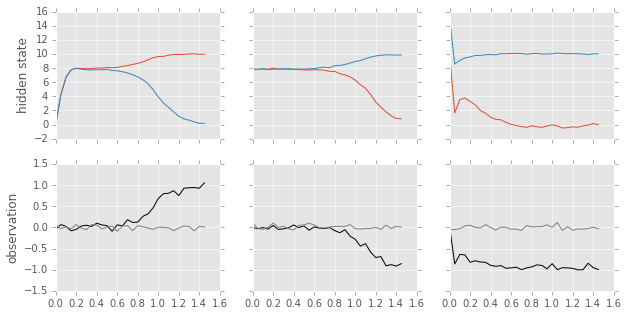

In [4]:
# instantiate BAttM
bam = BAttM()

# noise
bam.q = 1
bam.r = 0.05

# starting points: one at origin, one close to saddle, 
# one beyond saddle, but biased towards one fixed point
z0 = np.vstack((np.zeros((bam.nd)), bam.findSaddle(), [10, 15])).T
n0 = z0.shape[1]

# evolve discretised dynamics for a couple of time steps
nt = 30
dt = 0.05
T = np.arange(nt) * dt
X = np.zeros((bam.nD, nt, n0))
Z = np.zeros((bam.nd, nt, n0))
Z[:, 0, :] = z0
for i0 in range(n0):
    for t in range(1, nt):
        Z[:, t, i0] = Z[:, t-1, i0] + dt * bam.dynfun(Z[:, t-1, i0])
    
    # compute observations
    X[:, :, i0] = bam.obsfun(Z[:, :, i0])

# plot
axes = aux.plottr(Z, X, T)

The trajectories follow the dynamics that I expected from the phase space plot: When started from the origin (left), the dynamics moves the state to the saddle point, but, because of the noise, the state leaves the saddle and randomly moves into one of the two fixed points which are at $[10, 0]^T$ and $[0, 10]^T$ for the parameters defined above. Obviously, starting from the saddle (middle) simply skips the initial part of the trajectory, but otherwise behaves the same. Finally, when started from a position closer to one of the fixed points (right), the state will immediate move to the respective fixed point.

### Implementations of UT with different sigma point sets

#### Min set

The min set will provide the basic structure. Note that weights are recomputed anytime the dimensionality $D$ is changed.

In [5]:
class UT(object):
    """Implements the Unscented Transform (min set)."""

    _name = 'min set'

    def __init__(self, D):
        """Initialise weights."""

        # dimensionality in original space, will compute weights
        self.D = D


    @property
    def D(self):
        return self._D


    @D.setter
    def D(self, D):
        self._D = D

        self.setWeights()


    @property
    def N(self):
        """Number of sigma points."""

        return self.D + 1


    def setWeights(self):
        # weights for reconstructing the mean
        self.wm = np.hstack((1.0, np.zeros((self.D))))

        # weights for reconstructing the covariance
        self.wc = np.hstack((0.0, np.ones((self.D)) / self.D))


    def constructSigmaPoints(self, mean, cov):
        """Construct sigma points."""

        SP = mean[:, None].repeat(self.N, axis=1)
        SP[:, 1:] = SP[:, 1:] + np.sqrt(self.D) * linalg.cholesky(cov)

        return SP


    def performUT(self, mean, cov, trfun):
        """Performs the unscented transform."""

        # construct sigma points
        SP = self.constructSigmaPoints(mean, cov)

        # transform sigma points
        SP_tr = trfun(SP)

        # reconstruct mean and covariance from transformed sigma points
        return self.reconstruct(SP_tr)


    def performUTforUKF(self, mean, cov, dynfun, obsfun):
        """Performs the unscented transform twice for use within UKF."""

        # construct sigma points
        SP = self.constructSigmaPoints(mean, cov)

        # transform through dynamics function
        SPdyn = dynfun(SP)

        # reconstruct mean
        meandyn = SPdyn.dot(self.wm)

        # error between sigma points and mean
        errdyn = SPdyn - meandyn[:, None]

        # reconstruct covariance from errors
        covdyn = errdyn.dot((self.wc * errdyn).T)

        # same procedure with transform through observation function
        SPobs = obsfun(SPdyn)
        meanobs = SPobs.dot(self.wm)
        errobs = SPobs - meanobs[:, None]
        covobs = errobs.dot((self.wc * errobs).T)

        # compute cross-covariance between dynamic states and observations
        xcov = errdyn.dot((self.wc * errobs).T)

        return meandyn, covdyn, meanobs, covobs, xcov


    def reconstruct(self, S):
        """Reconstruct mean and covariance from sigma points.

        (D, N) = shape(S) where D is the dimensionality of the sigma points
                          and N is their number
        """
        mean = S.dot(self.wm)

        Sm = S - mean[:, None]
        cov = Sm.dot((self.wc * Sm).T)

        return mean, cov


    def printparams(self):
        return ''


    def __str__(self):
        desc = 'Unscented Transform (%s with %d sigma points)' % (
            self._name, self.N)

        parstr = self.printparams()

        if len(parstr) > 0:
            desc = desc + '\n' + parstr

        return desc
    
ut_min = UT(bam.nd)

#### Base set

The base set only differs in the selection of sigma points and weights.

In [6]:
class UT_base(UT):
    """Implements the Unscented Transform (base set)."""

    _name = 'base set'

    @property
    def N(self):
        """Number of sigma points."""

        return self.D * 2


    def setWeights(self):
        self.wm = np.ones((self.N)) / self.N
        self.wc = self.wm


    def constructSigmaPoints(self, mean, cov):
        SP = mean[:, None].repeat(self.N, axis=1)
        L = np.sqrt(self.D) * linalg.cholesky(cov)
        SP[:, :self.D] = SP[:, :self.D] + L
        SP[:, self.D:] = SP[:, self.D:] - L

        return SP
    
ut_base = UT_base(bam.nd)

#### Gauss and scaled sets

For the full UT, as usually used, I introduce the three parameters $\kappa$, $\alpha$ and $\beta$ where $\kappa$ should actually always be $\kappa=1$, as argued above. $\beta=2$ is a standard choice such that the Gauss set is recovered by setting $\alpha=\sqrt{3}$ while the scaled set corresponds to the UT with $\alpha \ll 1$, e.g., $\alpha=0.01$.

In [7]:
class UT_scaled(UT):
    """Implements the Unscented Transform (Gauss and scaled sets)."""

    _name = 'scaled set'

    def __init__(self, D):
        """Initialise parameters and weights."""

        # these default parameters implement the Gauss set
        self._alpha = np.sqrt(3)
        self._kappa = 1.0
        self._beta = 2.0

        # dimensionality in original space, will compute weights
        self.D = D


    @property
    def name(self):
        if np.allclose([np.sqrt(3), 1.0, 2.0],
                       [self.alpha, self.kappa, self.beta]):
            return 'Gauss set'
        else:
            return self._name


    @property
    def N(self):
        """Number of sigma points."""

        return self.D * 2 + 1


    @property
    def alpha(self):
        """Scale parameter."""

        return self._alpha


    @alpha.setter
    def alpha(self, alpha):
        self._alpha = float(alpha)

        self.setWeights()


    @property
    def kappa(self):
        """Another scale parameter."""

        return self._kappa


    @kappa.setter
    def kappa(self, kappa):
        self._kappa = float(kappa)

        self.setWeights()


    @property
    def beta(self):
        """Scale correction parameter."""

        return self._beta


    @beta.setter
    def beta(self, beta):
        self._beta = float(beta)

        self.setWeights()


    def setWeights(self):
        a2k = self.alpha**2 * self.kappa
        self.wm = np.ones((self.N)) / (2 * a2k)
        self.wc = np.copy(self.wm)

        self.wm[0] = (a2k - self.D) / a2k
        self.wc[0] = self.wm[0] + 1 - self.alpha**2 + self.beta


    def constructSigmaPoints(self, mean, cov):
        SP = mean[:, None].repeat(self.N, axis=1)
        L = self.alpha * np.sqrt(self.kappa) * linalg.cholesky(cov)
        SP[:, 1:self.D+1] = SP[:, 1:self.D+1] + L
        SP[:, self.D+1:] = SP[:, self.D+1:] - L

        return SP


    def printparams(self):
        return 'alpha = %5.3f\nbeta  = %5.3f\nkappa = %5.3f' % (self.alpha,
                                                                self.beta,
                                                                self.kappa)
    
ut_gauss = UT_scaled(bam.nd)
ut_scaled = UT_scaled(bam.nd)
ut_scaled.alpha = 0.01

#### Mean set

The mean set holds $w_0$ constant by increasing the scale of the sigma points with the dimensionality. My standard choice of $w_0 = 1/3$ implements the Gauss set in two dimensions.

In [8]:
class UT_mean(UT):
    """Implements the Unscented Transform (mean set)."""

    _name = 'mean set'


    def __init__(self, D):
        """Initialise parameters and weights."""

        # this default value implements a Gauss set in 2D
        self._w0 = 1.0 / 3.0

        # dimensionality in original space, will compute weights
        self.D = D


    @property
    def D(self):
        return self._D


    @D.setter
    def D(self, D):
        self._D = D
        self._kappa = D / (1 - self.w0)

        self.setWeights()


    @property
    def N(self):
        return 2 * self.D + 1


    @property
    def w0(self):
        return self._w0


    @w0.setter
    def w0(self, w0):
        self._w0 = w0
        self._kappa = self.D / (1 - w0)

        self.setWeights()


    def setWeights(self):
        self.wm = np.r_[self.w0, np.ones(2 * self.D) / (2 * self._kappa)]
        self.wc = self.wm


    def constructSigmaPoints(self, mean, cov):
        SP = mean[:, None].repeat(self.N, axis=1)
        L = np.sqrt(self._kappa) * linalg.cholesky(cov)
        SP[:, 1:self.D+1] = SP[:, 1:self.D+1] + L
        SP[:, self.D+1:] = SP[:, self.D+1:] - L
        
        return SP


    def printparams(self):
        return 'w0 = %5.3f with kappa = %5.3f' % (self.w0, self._kappa)
    

ut_mean = UT_mean(bam.nd)

### Naive Sampling

For comparison I will use naive sampling. For that I will assume Gaussian distributions. I only need a function which takes mean, covariance, transform function and the number of samples as input and returns estimates of the transformed mean and covariance.

In [9]:
def naiveSamplingEstimate(mean, cov, trfun, N=None):
    # if no covariance, mean contains samples
    if cov is None:
        S = mean
    # else sample from Gaussian using numpy
    else:
        S = np.random.multivariate_normal(mean, cov, int(N)).T

    # project through transform function
    Str = trfun(S)

    # estimate transformed mean
    meantr = np.mean(Str, 1)

    # estimate transformed covariance
    covtr = np.cov(Str)

    return meantr, covtr, Str

I can now verify that sampling and my performance measure $W$ work. I do this by applying the naive sampling estimate without transformation. When I increase the number of samples, the Wasserstein distance $W$ between true and estimated distributions should decrease.

As test case I use the following mean and covariance:

In [10]:
mean = np.arange(1, 5, dtype=float)
print mean

[ 1.  2.  3.  4.]


In [11]:
cov = np.diag(mean)
print cov

[[ 1.  0.  0.  0.]
 [ 0.  2.  0.  0.]
 [ 0.  0.  3.  0.]
 [ 0.  0.  0.  4.]]


I will use an exponential increase in the number of samples and will repeat each estimate 20 times to estimate the variability induced by different samples.

In [12]:
nsample = 10 ** np.arange(1, 6)
nrep = 20
Dis = np.zeros((nrep, nsample.size))
for i in range(nsample.size):
    for rep in range(nrep):
        meantr, covtr, _ = naiveSamplingEstimate(mean, cov, lambda x: x, nsample[i])
        Dis[rep, i] = WassDist(mean, cov, meantr, covtr)

Here is a plot of the relationship between $D_{KL}$ and the number of samples.

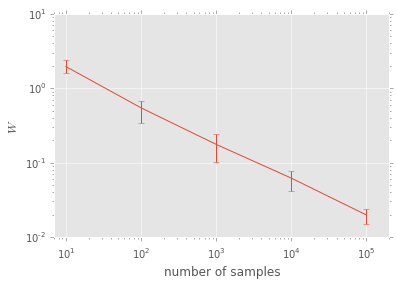

In [13]:
Dismean = Dis.mean(axis=0)
Perc = np.percentile(Dis, [5, 95], axis=0)
plt.errorbar(nsample, Dismean, np.c_[Dismean - Perc[0, :], Perc[1, :] - Dismean].T)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('number of samples')
plt.gca().set_ylabel('$W$')
plt.gca().set_xlim([nsample[0]-3, 2*nsample[-1]]);

$W$ nicely tends to 0 as I increase the number of samples. It even appears to be a roughly linear relationship. So my sampling procedure and the performance measure work as intended.

### Experiments

I'm interested in the accuracy of the UT depending on
- the nonlinearity of $\bf h$
- the amount of uncertainty, i.e., the variances of $p({\bf r})$
- the dimensionality of ${\bf r}$ and ${\bf o}$

Although these dependencies may interact I will investigate them in isolation to keep the complexity of the corresponding experiments low. Further, I wish to quanitfy 
- the computational efficiency of the UT compared to naive sampling
- the benefit of taking Gaussianity of $p({\bf r})$ into account

In the following I will go through these points in turn and will end in a demonstration of using different sigma point sets inside the Unscented Kalman Filter.

#### Effects of nonlinearity

I will here investigate how the nonlinearity of $\bf h$ affects the accuracy of the UT variants. 

It is hard to pin down an intuitive measure of nonlinearity, i.e., when is a function more or less nonlinear? I shall not attempt this here. Instead, I note that the observation and dynamics functions of the probabilistc model defined above are locally more linear for some inputs than for others. This is because their nonlinearity results from a sigmoid function which is locally linear around its inflection point and constant for very small and very large values, as shown in the following figure (red line).

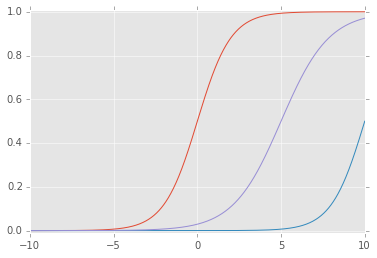

In [14]:
sigmoid = lambda x, shift, slope: 1.0 / (1.0 + np.exp(-slope * (x - shift)))
xx = np.linspace(-10.0, 10.0, 1000)
plt.plot(xx, sigmoid(xx, 0, 1),                    # standard sigmoid
         xx, sigmoid(xx, bam.hopg, 1),             # dynamics function sigmoid
         xx, sigmoid(xx, bam.oshift, bam.oslope)); # observation function sigmoid
plt.gca().set_ylim([-0.01, 1.01]);

In the dynamics function, the inflection point of the sigmoid is moved to the value of `hopg` which is 10 (cf. blue line). This means that the dynamics is roughly linear at its stable fixed points, because there one state variable $z_i=10$ while the others are 0 which is mapped to a constant value (0). In contrast, the saddle point ($\approx [7.9, 7.9]^T$) resides in a nonlinear part of the dynamics, because the corresponding sigmoid has a large curvature between 6 and 9.

In the observation function, the inflection point of the sigmoid is at `hopg/2` and its slope has been decreased such that the extent of the approximately linear region is slightly stretched (cf. violet line). Therefore, both, the stable fixed points and the saddle point of the dynamics, lie in the nonlinear region of the observation function, but it could still be argued that the saddle point lies in a more nonlinear region, because of greater curvature around this region. The point at [`hopg/2`, `hopg/2`$]^T$, on the other hand, should lie in more or less linear regions of the observation and dynamics functions.

Based on these considerations I choose the following points around which I want to investigate the performance of the UT:

In [15]:
Z = np.vstack((np.ones(bam.nd) * bam.oshift,             # point in linear region
               bam.findSaddle(),                         # saddle point of dynamics
               np.hstack((bam.hopg, np.zeros(bam.nd-1))) # a stable fixed point
              )).T
print Z

[[  5.           7.87196527  10.        ]
 [  5.           7.87196527   0.        ]]


I further choose a moderate variance around these points to (mostly) stay within the linear, or nonlinear regions, respectively.

In [16]:
C = np.eye(bam.nd)
print C

[[ 1.  0.]
 [ 0.  1.]]


As first step, I estimate the true transformed distributions by sampling and projecting.

In [17]:
num = Z.shape[1]
nsample = 10000

# set noise after transformation to 0 to concentrate
# on the effects of transformation
bam.r = 0.0
bam.q = 0.0

# make full dynamics function
# (model function is only the continuous change dz/dt)
dynfun = lambda x: x + dt * bam.dynfun(x)

# initialise output arrays
meantrue = np.zeros((bam.nd, num, 2))
covtrue = np.zeros((bam.nd, bam.nd, num, 2))
Strue = np.zeros((bam.nd, nsample, num, 2))
for i in range(num):
    meantrue[:, i, 0], covtrue[:, :, i, 0], Strue[:, :, i, 0] = \
        naiveSamplingEstimate(Z[:, i], C, bam.obsfun, nsample)
    meantrue[:, i, 1], covtrue[:, :, i, 1], Strue[:, :, i, 1] = \
        naiveSamplingEstimate(Z[:, i], C, dynfun, nsample)

Here is a visualisation of the result. The top row of panels shows the distributions transformed through the observation function and the bottom row shows the distributions transformed through the dynamics function. For the observation function I plot histograms, because the transformed distribution is effectively only one-dimensional. For the dynamics function I plot 500 sample points in 2D. All panels are augmented by a visualisation of the Gaussian densities with the mean and covariance estimated from the samples (black lines). For the observation function this shows the values of the corresponding probability density function. For the dynamics function I plot an ellipse which encloses 90% of the probability mass of the Gaussian.

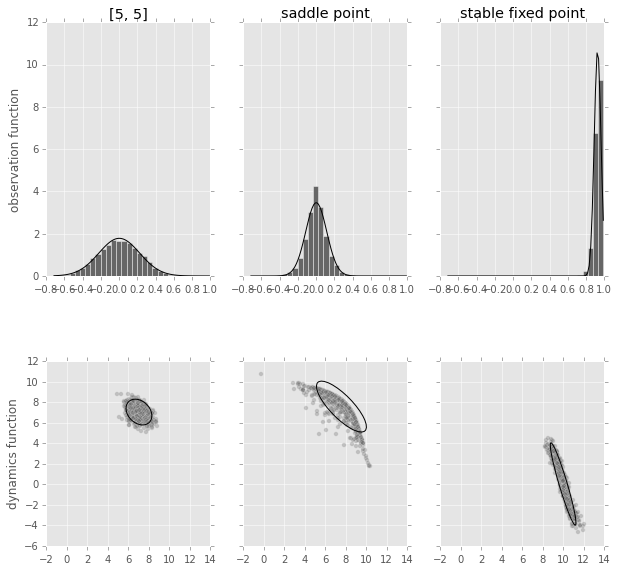

In [18]:
funlabels = ['observation function', 'dynamics function']
pointlabels = ['[5, 5]', 'saddle point', 'stable fixed point']
aux.plotSamples(Strue, meantrue, covtrue, 
                ylabels=funlabels, titles=pointlabels);

The plot confirms some of my considerations of the effect of nonlinearity from above: For the dynamics function the distribution centred at the saddle point transforms to a distribution that is clearly non-Gaussian indicating strong nonlinearity in the transformation whereas the Gaussian approximation is better for the other two test points, at least visually. For the observation function it appears that the Gaussian density fits the histogram density of the samples reasonably well for the point $[5, 5]^T$, but there are larger differences for the saddle and stable fixed points. Overall, however, the Gaussians appear to approximate these 1D distributions well.

I will now repeat my analysis of naive sampling from above to determine how accurately I can reconstruct the true mean and covariance with a given number of samples.

number of samples: [  4   6  10  18  34  66 130 258 514]


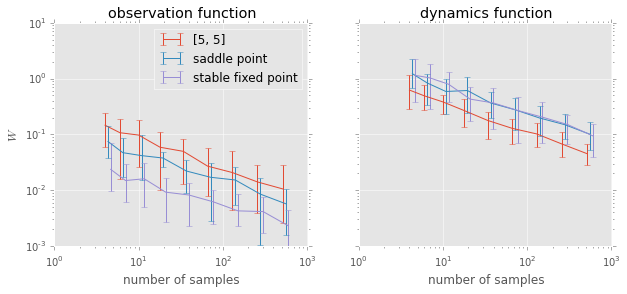

In [19]:
nsample = 2 + bam.nd ** np.arange(1, 10)
print 'number of samples: ' + nsample.__str__()
nrep = 20
desDis = np.array([10.0, 1.0, 0.1, 0.01]);
trfuns = (bam.obsfun, dynfun)

estN = aux.plotSamplingDis(Z, C, meantrue, covtrue, nsample, nrep, trfuns, 
                           desDis, funlabels, pointlabels)

The plot shows how $W$ decreases, i.e., how the accuracy of the estimated mean and covariance increase, as I increase the number of samples. The different lines in each panel represent the Wasserstein distance after transformation of the corresponding test points through the observation function (left) and the dynamics function (right). When transforming through the observation function the performance is worst for point $[5, 5]^T$ and best for the stable fixed point. The performance of the sampling approximation, therefore, appears to depend on the spread of the transformed distribution with larger spread leading to worse approximations. The same picture holds for the dynamics function where the point $[5, 5]^T$ has the smallest spread of the transformed distribution and sampling performs best compared to the other test points. The plot also clearly shows that the Wasserstein distance strongly depends on the intrinsic dimensionality of the distributions: The distributions transformed through the observation function are effectively one-dimensional and have overall lower Wasserstein distances than the two-dimensional distributions resulting from transformation through the dynamics function.

Using linear interpolation I have also estimated the number of samples you need to reach a given average accuracy. These are helpful later to judge the efficiency of the UT approximations. For the observation function the numbers of samples are:

In [20]:
print pandas.DataFrame(estN[:, :, 0].round(), desDis, pointlabels).to_string()

       [5, 5]  saddle point  stable fixed point
10.00       4             4                   4
1.00        4             4                   4
0.10        9             4                   4
0.01      NaN           229                  17


The table shows that I need less then 10 random samples to achieve an average accuracy of $W=0.1$ for all test points. The next step to $W=0.01$, however, requires considerably more samples where the numbers reflect the differences discussed for the plots above, especially, they show that you need many more samples (NaN means more than 514) to reach high performance (low $W$) for the point [5, 5]^T than for the other test points.

For the dynamics function the numbers of samples are:

In [21]:
print pandas.DataFrame(estN[:, :, 1].round(), desDis, pointlabels).to_string()

       [5, 5]  saddle point  stable fixed point
10.00       4             4                   4
1.00        4             5                   6
0.10      136           NaN                 488
0.01      NaN           NaN                 NaN


Again, the numbers follow the findings from above, as expected, and particularly show that I need only very few samples to reach mediocre accuracy, but need about 100 times more samples to reduce the distance by one order of magnitude for wide transformed distributions.

So how do the different UT variants perform in these cases? Here I compute the KL-based performance measure for them:

In [22]:
UTs = (ut_min, ut_base, ut_gauss, ut_scaled)
nut = len(UTs)
meanUT = np.zeros((bam.nd, num, nut, 2))
covUT = np.zeros((bam.nd, bam.nd, num, nut, 2))
Dis = np.zeros((num, nut, 2))
for uti, ut in enumerate(UTs):
    for i in range(num):
        meanUT[:, i, uti, 0], covUT[:, :, i, uti, 0] = \
            ut.performUT(Z[:, i], C, bam.obsfun)
        meanUT[:, i, uti, 1], covUT[:, :, i, uti, 1] = \
            ut.performUT(Z[:, i], C, dynfun)
        Dis[i, uti, 0] = WassDist(meantrue[:, i, 0], covtrue[:, :, i, 0],
                                  meanUT[:, i, uti, 0], covUT[:, :, i, uti, 0])
        Dis[i, uti, 1] = WassDist(meantrue[:, i, 1], covtrue[:, :, i, 1],
                                  meanUT[:, i, uti, 1], covUT[:, :, i, uti, 1])

First, I look at the performance on the observation function (in terms of $W$):

In [23]:
utlabels = ('UT min', 'UT base', 'UT Gauss', 'UT scaled')
print pandas.DataFrame(Dis[:, :, 0], pointlabels, utlabels).to_string()

                    UT min  UT base  UT Gauss  UT scaled
[5, 5]              0.0051   0.0051    0.0032     0.0234
saddle point        0.0444   0.0015    0.0054     0.0120
stable fixed point  0.0140   0.0052    0.0018     0.0036


The table shows that the UT with the mean set consistently produces an excellent approximation of the true mean and covariance ($W<0.01$) irrespective of the underlying test point and it only uses $2*D+1=5$ points for that. To achieve comparable performance with random samples I would have needed over 500 samples at the point $[5, 5]^T$. The other sigma point sets performed worse than the mean set. As expected, the min set is typically worst. The base set also outperforms the scaled set on 2 test points and outperforms the mean set at the saddle point. Because the Wasserstein distances are generally low, however, I don't want to overinterpret these differences.

For the dynamics function the distances $W$ are:

In [24]:
print pandas.DataFrame(Dis[:, :, 1], pointlabels, utlabels).to_string()

                    UT min  UT base  UT Gauss  UT scaled
[5, 5]              0.0853   0.0164    0.0109     0.0589
saddle point        0.6215   0.2649    0.1043     0.3048
stable fixed point  0.0841   0.0833    0.0713     0.3638


Here, the mean set performs best for all test points and particularly so in the nonlinear region around the saddle point. The distances increased by an order of magnitude for the saddle point which I expected based on the dependence of the distance on the dimensionality of the distribution. In the nonlinear region of the dynamics function (saddle point) the UT performs worst across all sigma point sets. Strangely, the scaled set is equally bad at the stable fixed point whereas even the min set performs reasonably well there.

Here are the corresponding plots of the transformed distributions, but this time with the UT approximations:

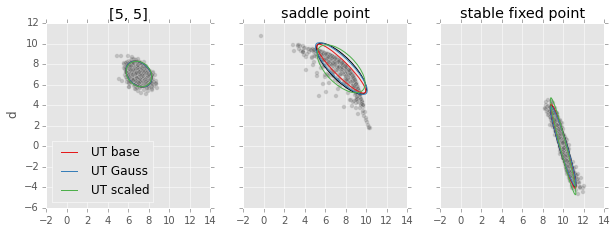

In [25]:
fun = 1
ax = aux.plotSamples(Strue[:, :, :, fun], 
                     meantrue[:, :, fun], covtrue[:, :, :, fun], 
                     meanUT=meanUT[:, :, 1:, fun], covUT=covUT[:, :, :, 1:, fun], 
                     titles=pointlabels, ylabels=funlabels[fun], 
                     utlabels=utlabels[1:])

For the saddle point, I see that the ellipse of the mean set (blue) is very close to the true ellipse estimated from many samples (black). Whereas the base set (red) leads to a narrower distribution, the scaled set (green) leads to a wider distribution. Overall, however, the plot shows that distances below 0.5 give reasonably good approximations of the underlying mean and covariance of the true distribution in two dimensions.

In conclusion, the results presented here indicate that the mean set produces the best approximations both in linear and nonlinear regions of the transformation function. The small variances of the source distribution $p({\bf r})$ used here, however, meant that the transformation functions produced only moderate nonlinearities such that all UT approximations captured the transformed mean and covariance with an acceptable accuracy.

#### Effects of large uncertainty

Increasing the uncertainty in $p({\bf r})$ means that the distribution spreads over larger parts of the domain of the transformation function $\bf h$. For both, the observation and the dynamics functions defined above, this means that the source distribution $p({\bf r})$ maps through larger nonlinearities. I consequently expect that the UT approximations get worse with increasing uncertainty and that the differences between the sigma point sets become more salient.

I will test this now using the following standard deviations in $p({\bf r})$:

In [26]:
stdsr = np.array([2.0, 4.0, 8.0])

I can simply repeat the analysis from above by replacing different test points with different uncertainties. I will use $[5, 5]^T$ as the test point, because this showed originally no nonlinearities and lead to very good approximations. So here are the estimates of the true mean and covariance:

In [27]:
testp = 0
num = stdsr.size
nsample = 10000

meantrue = np.zeros((bam.nd, num, 2))
covtrue = np.zeros((bam.nd, bam.nd, num, 2))
Strue = np.zeros((bam.nd, nsample, num, 2))
for i in range(num):
    C = stdsr[i]**2 * np.eye(bam.nd)
    meantrue[:, i, 0], covtrue[:, :, i, 0], Strue[:, :, i, 0] = \
        naiveSamplingEstimate(Z[:, testp], C, bam.obsfun, nsample)
    meantrue[:, i, 1], covtrue[:, :, i, 1], Strue[:, :, i, 1] = \
        naiveSamplingEstimate(Z[:, testp], C, dynfun, nsample)

The transformed distributions look like this:

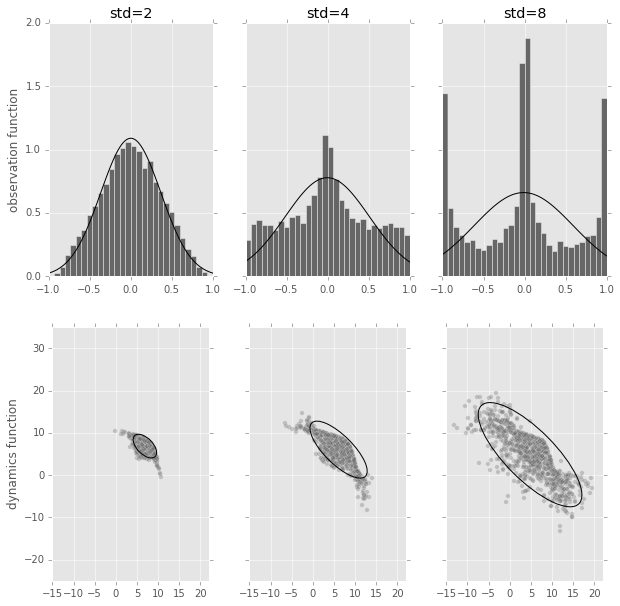

In [28]:
stdlabels = ['std=%d' % y for y in stdsr]
ax = aux.plotSamples(Strue, meantrue, covtrue, 
                     ylabels=funlabels, titles=stdlabels, nplot=1000);
ax[1, 0].set(ylim=(-25, 35), xlim=(-15, 22));

The plot clearly shows that with increasing uncertainty the transformed distributions depart more and more from Gaussianity. The observation function leads eventually to a distribution with three separate modes and the distribution resulting from the dynamics function also exhibits an increasingly complex shape.

I can compute the UT approximations as before:

In [29]:
meanUT = np.zeros((bam.nd, num, nut, 2))
covUT = np.zeros((bam.nd, bam.nd, num, nut, 2))
Dis = np.zeros((num, nut, 2))
for uti, ut in enumerate(UTs):
    for i in range(num):
        C = stdsr[i]**2 * np.eye(bam.nd)
        meanUT[:, i, uti, 0], covUT[:, :, i, uti, 0] = \
            ut.performUT(Z[:, testp], C, bam.obsfun)
        meanUT[:, i, uti, 1], covUT[:, :, i, uti, 1] = \
            ut.performUT(Z[:, testp], C, dynfun)
        Dis[i, uti, 0] = WassDist(meantrue[:, i, 0], covtrue[:, :, i, 0],
                                  meanUT[:, i, uti, 0], covUT[:, :, i, uti, 0])
        Dis[i, uti, 1] = WassDist(meantrue[:, i, 1], covtrue[:, :, i, 1],
                                  meanUT[:, i, uti, 1], covUT[:, :, i, uti, 1])

leading to the following divergences for the observation function:

In [30]:
print pandas.DataFrame(Dis[:, :, 0], stdlabels, utlabels).to_string()

       UT min  UT base  UT Gauss  UT scaled
std=2  0.0127   0.0127    0.0243     0.1289
std=4  0.0314   0.0314    0.1107     0.4774
std=8  0.1043   0.1043    0.1954     1.3761


Here it is the base set and, to my surprise, the min set which produce the best approximations. The Gauss set tends to overconcentrate probability mass around the mean and consequently underestimates the tails and extra modes of the transformed distribution $p({\bf o})$. Overall, however, the Gauss set at least gives a reasonable approximation also for `std=8`. The scaled set, however, completely overestimates the variance of the distribution for `std=4` and `std=8`, as shown in the following plot.

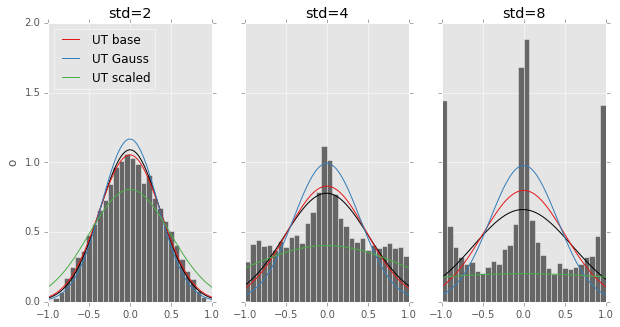

In [31]:
fun = 0
ax = aux.plotSamples(Strue[:, :, :, fun], meantrue[:, :, fun], covtrue[:, :, :, fun], 
                     meanUT=meanUT[:, :, 1:, fun], covUT=covUT[:, :, :, 1:, fun], 
                     titles=stdlabels, ylabels=funlabels[fun], 
                     utlabels=utlabels[1:])

I explain the overestimation of the variance by the scaled set with its locality: The scaled set estimates the spread of the transformed distribution only locally around the point $[5, 5]^T$ where the observation function has a sizeable linear slope. The sigmoid in the observation function, however, limits the spread of the transformed distribution which is never accounted for by the scaled set.

For the dynamics function the Gauss set again provides the best approximation across all standard deviations of the source distribution $p({\bf r})$:

In [32]:
print pandas.DataFrame(Dis[:, :, 1], stdlabels, utlabels).to_string()

       UT min  UT base  UT Gauss  UT scaled
std=2  0.5353   0.1438    0.1753     0.5457
std=4  2.5536   1.9359    1.0216     2.3950
std=8  4.9543   1.7654    1.2362     5.1774


The base set has a striking lapse for `std=4`. The large distance results from underestimation of the spread of the transformed distribution:

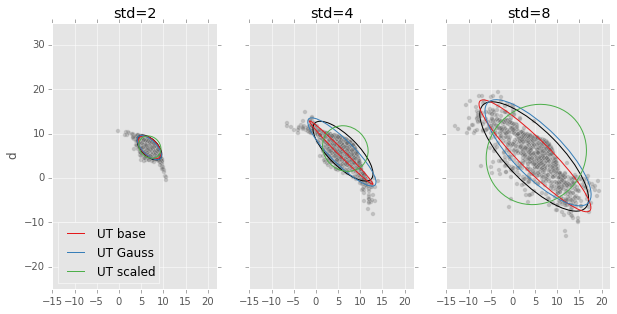

In [33]:
fun = 1
ax = aux.plotSamples(Strue[:, :, :, fun], 
                     meantrue[:, :, fun], covtrue[:, :, :, fun], 
                     meanUT=meanUT[:, :, 1:, fun], covUT=covUT[:, :, :, 1:, fun], 
                     titles=stdlabels, ylabels=funlabels[fun], 
                     utlabels=utlabels[1:])
ax[0, 0].set(xlim=(-15, 22), ylim=(-25, 35));

I don't quite understand why this happens. It at least gets the mean roughly right and the spread along the major direction of variance is also captured.

The scaled set again suffers from its locality: The spread of the sigma points around the test point $[5, 5]^T$ is apparently, even for the largest standard deviation, so low that the specific effect of the dynamics (the pull towards the stable fixed points) does not enter the approximation such that the approximated covariance remains roughly isotropic.

The following code repeats all analysis steps for another test point (preset to the stable fixed point here). The overall results are the same as for point $[5, 5]^T$: The base and Gauss sets produce comparably good approximations with slight advantages for the Gauss set whereas the scaled set performs considerably worse for uncertain source distributions, i.e., when $p({\bf r})$ has large (co)variances.

test point: 
[ 10.   0.]

observation function:
       UT min  UT base  UT Gauss  UT scaled
std=2  0.0664   0.0370    0.0118     0.0335
std=4  0.2458   0.0529    0.0349     0.0288
std=8  0.5080   0.0404    0.1842     0.7675

dynamics function:
       UT min  UT base  UT Gauss  UT scaled
std=2  0.2271   0.2219    0.3276     1.6927
std=4  0.3628   0.3303    0.7243     5.3090
std=8  3.5845   1.2737    1.0318    12.6382


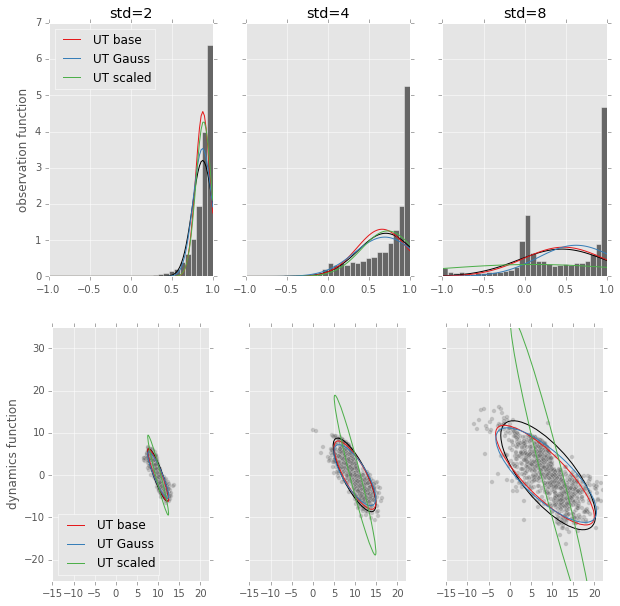

In [34]:
testp = 2
print 'test point: \n' + Z[:, testp].__str__() + '\n'

meantrue = np.zeros((bam.nd, num, 2))
covtrue = np.zeros((bam.nd, bam.nd, num, 2))
Strue = np.zeros((bam.nd, nsample, num, 2))
for i in range(num):
    C = stdsr[i]**2 * np.eye(bam.nd)
    meantrue[:, i, 0], covtrue[:, :, i, 0], Strue[:, :, i, 0] = \
        naiveSamplingEstimate(Z[:, testp], C, bam.obsfun, nsample)
    meantrue[:, i, 1], covtrue[:, :, i, 1], Strue[:, :, i, 1] = \
        naiveSamplingEstimate(Z[:, testp], C, dynfun, nsample)
        
meanUT = np.zeros((bam.nd, num, nut, 2))
covUT = np.zeros((bam.nd, bam.nd, num, nut, 2))
Dis = np.zeros((num, nut, 2))
for uti, ut in enumerate(UTs):
    for i in range(num):
        C = stdsr[i]**2 * np.eye(bam.nd)
        meanUT[:, i, uti, 0], covUT[:, :, i, uti, 0] = \
            ut.performUT(Z[:, testp], C, bam.obsfun)
        meanUT[:, i, uti, 1], covUT[:, :, i, uti, 1] = \
            ut.performUT(Z[:, testp], C, dynfun)
        Dis[i, uti, 0] = WassDist(meantrue[:, i, 0], covtrue[:, :, i, 0],
                                  meanUT[:, i, uti, 0], covUT[:, :, i, uti, 0])
        Dis[i, uti, 1] = WassDist(meantrue[:, i, 1], covtrue[:, :, i, 1],
                                  meanUT[:, i, uti, 1], covUT[:, :, i, uti, 1])

print 'observation function:'
print pandas.DataFrame(Dis[:, :, 0], stdlabels, utlabels).to_string()
print ''
print 'dynamics function:'
print pandas.DataFrame(Dis[:, :, 1], stdlabels, utlabels).to_string()

ax = aux.plotSamples(Strue[:, :, :, :], 
                     meantrue[:, :, :], covtrue[:, :, :, :], 
                     meanUT=meanUT[:, :, 1:, :], covUT=covUT[:, :, :, 1:, :], 
                     titles=stdlabels, ylabels=funlabels, 
                     utlabels=utlabels[1:])
ax[1, 0].set(xlim=(-15, 22), ylim=(-25, 35));

#### Effects of the dimensionalities of $\bf r$ and $\bf o$

I can easily increase the dimensionality of the Bayesian attractor model without changing the main properties of its dynamics. For each added dimension a new stable fixed point will appear on the corresponding coordinate axis in state space, e.g., at $[0, 0, 10]^T$ for three dimensions. Additionally, the observation function becomes truly two-dimensional for larger dimensionality of the dynamics, because I map the stable fixed points to equally spaced points around the unit circle. Consequently, the observation function becomes considerably more nonlinear as the dimensionality increases. At the same time, however, the transformed distribution resembles more and more a circular Gaussian, because each dimension adds a term in a sum of random variables in the observation function.

Below I generate results for a combination of test point and spread of the source distribution (`std`) for increasing dimensionality (`nds`). The preselected values are a stable fixed point as test point and large spread of `std=8`. I chose those values, because they reveal problems of the scaled set. Some other settings and results are discussed below, but you should explore the behaviour of the UTs in response to different settings for yourself.

The code below generates the tables with the Wasserstein distances $W$ for the observation and dynamics functions as well as two plots. The first plot visualises the results for the observation function as above just that the distributions are now in 2D. The second plot shows the true and approximated distributions for the dynamics function, but only for one of the dimensionalities. This plot visualises the high-dimensional distribution by showing all distinct 2D-slices of the distribution.

Notice that I now explicitly include the mean set into the list of UTs, because the Gauss and mean sets differ for $D \neq 2$. Also notice that the Gauss and base sets are equal for $D = 3$.

test point: stable fixed point
std = 8.0

observation function:
       UT min  UT base  UT Gauss  UT scaled  UT mean
nd=3   0.5436   0.2019    0.2019     0.8623   0.3156
nd=5   0.5027   0.3555    0.1875     0.7924   0.4719
nd=11  0.5860   0.6962    0.1759     0.7209   0.8153

dynamics function:
        UT min  UT base  UT Gauss  UT scaled  UT mean
nd=3    6.2625   3.6862    3.6862    20.1080   3.1110
nd=5   10.7211   6.2431   12.2691    33.2884   6.8031
nd=11  30.3067  22.4981       NaN    71.1913  25.7997


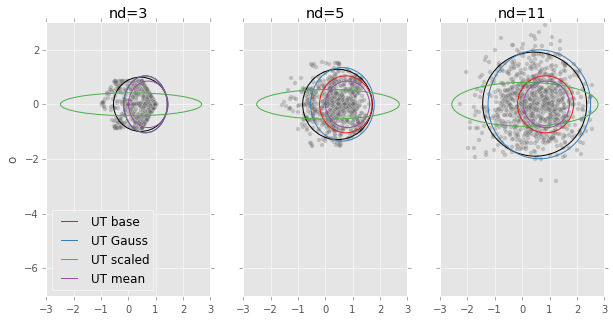

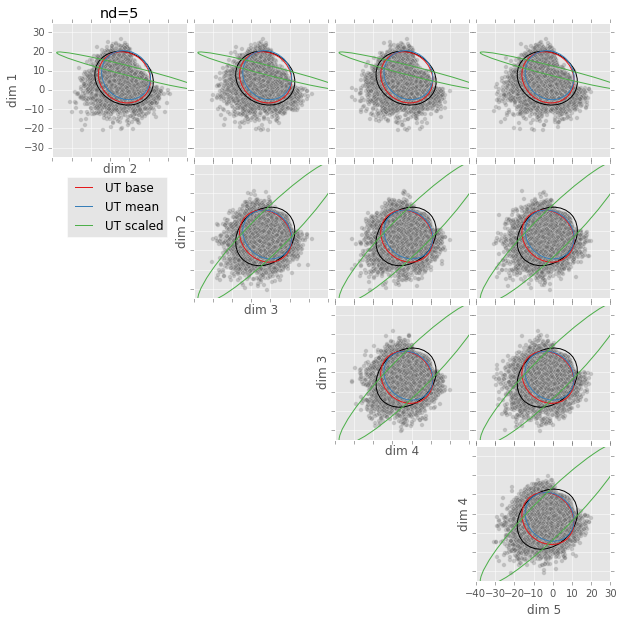

In [35]:
# different dimensionalities of the dynamics
nds = [3, 5, 11]
num = len(nds)

# select test point (0: 5*ones, 1: saddle, 2: stable FP)
testp = 2
print 'test point: ' + pointlabels[testp]

# spread of source samples (standard deviation)
std = 8.0
print 'std = %3.1f' % (std, ) + '\n'

# how strongly should the mean be weighted in the mean set (default: 1/3)?
ut_mean.w0 = 1/3.0

UTs = (ut_min, ut_base, ut_gauss, ut_scaled, ut_mean)
nut = len(UTs)
utlabels = ('UT min', 'UT base', 'UT Gauss', 'UT scaled', 'UT mean')

meantrueobs = np.zeros((bam.nD, num))
covtrueobs = np.zeros((bam.nD, bam.nD, num))
Strueobs = np.zeros((bam.nD, nsample, num))
meantruedyn = []
covtruedyn = []
Struedyn = []
meanUTobs = np.zeros((bam.nD, num, nut))
covUTobs = np.zeros((bam.nD, bam.nD, num, nut))
meanUTdyn = []
covUTdyn = []
Dis = np.zeros((num, nut, 2))
Z = []
C = []
for ndi, nd in enumerate(nds):
    # set dimensionality of dynamics
    bam.nd = nd

    # create test point
    if testp == 0:
        Z.append(5.0 * np.ones(nd))
    elif testp == 1:
        Z.append(bam.findSaddle())
    else:
        Z.append(np.r_[bam.hopg, np.zeros(nd-1)])
    
    C.append(std**2 * np.eye(nd))
    
    dynfun = lambda x: x + dt * bam.dynfun(x)
    
    meantrueobs[:, ndi], covtrueobs[:, :, ndi], Strueobs[:, :, ndi] = \
        naiveSamplingEstimate(Z[ndi], C[ndi], bam.obsfun, nsample)
    mt, ct, St = naiveSamplingEstimate(Z[ndi], C[ndi], dynfun, nsample)
    
    meantruedyn.append(mt)
    covtruedyn.append(ct)
    Struedyn.append(St)
    
    mtUT = np.zeros((nd, nut))
    ctUT = np.zeros((nd, nd, nut))
    for uti, ut in enumerate(UTs):
        ut.D = nd
        meanUTobs[:, ndi, uti], covUTobs[:, :, ndi, uti] = ut.performUT(Z[ndi], C[ndi], 
                                                                        bam.obsfun)
        mtUT[:, uti], ctUT[:, :, uti] = ut.performUT(Z[ndi], C[ndi], dynfun)
        
        Dis[ndi, uti, 0] = WassDist(meantrueobs[:, ndi], covtrueobs[:, :, ndi],
                                    meanUTobs[:, ndi, uti], covUTobs[:, :, ndi, uti])
        Dis[ndi, uti, 1] = WassDist(mt, ct, mtUT[:, uti], ctUT[:, :, uti])
        
    meanUTdyn.append(mtUT)
    covUTdyn.append(ctUT)

ndlabels = ['nd=%d' %(y, ) for y in nds]

print 'observation function:'
print pandas.DataFrame(Dis[:, :, 0], ndlabels, utlabels).to_string()
ax = aux.plotSamples(Strueobs, 
                     meantrueobs, covtrueobs, 
                     meanUT=meanUTobs[:, :, 1:], covUT=covUTobs[:, :, :, 1:], 
                     titles=ndlabels, ylabels=funlabels[0], 
                     utlabels=utlabels[1:])
ax[0, 0].set_ylim([-7, 3]);

print '\ndynamics function:'
print pandas.DataFrame(Dis[:, :, 1], ndlabels, utlabels).to_string()

ndi = 1
utinds = np.array([1, 4, 3])
utl = [utlabels[i] for i in utinds]
axes = aux.plotHDSamples(Struedyn[ndi], meantruedyn[ndi], covtruedyn[ndi], 
                  title=ndlabels[ndi], meanUT=meanUTdyn[ndi][:, utinds], 
                  covUT=covUTdyn[ndi][:, :, utinds], utlabels=utl)

__Results for the stable fixed point.__ For the observation function I observe that the transformed distributions are reasonably well approximated by all but the scaled set which underestimates the spread of the transformed distribution in one dimension irrespective of the dimensionality. Mean and base sets, however, also tend to underestimate the spread of the transformed distribution which becomes more severe as the dimensionality increases. The Gauss set works exceptionally well, even as the dimensionality of the source distribution, $p({\bf r})$, increases. 

Unfortunately, the Gauss set fails completely when the dimensionality of the transformed distribution, $p({\bf o})$, increases, as it is the case when transforming through the dynamics function. This is because of the negative weight of the 0th sigma point (the mean) which leads to approximated covariance matrices that are not positive definite (producing $W$ = `NaN`). I do not show the Gauss set in the slice plot above. Instead, the plot shows the poor performance of the scaled set which severely underestimates the spread of the transformed distribution in the dimension of the one state variable that is not 0 in the stable fixed point (`dim 1` here). Note, though, that this underestimation is due to severe overestimation of the spread along the other dimensions. The other sigma point sets perform much better, but slightly underestimate the spread of the transformed distribution. 

__Results for the saddle point.__ Whereas the scaled set continues to overestimate the spread of the transformed distribution, the other sigma point sets considerably underestimate it at the saddle point. Overall, however, the Wasserstein distances show that the base and mean sets clearly outperform the scaled set with slight advantages for the base set over the mean set.

__Results for the point $[5, \dots, 5]^T$.__ Due to the similarity of this test point and the saddle point the base and mean sets perform very similar for the point $[5, \dots, 5]^T$ (underestimation of spread and increase of distances with dimensionality). The scaled set performs best among the three test points for this point, because it only slightly overestimates the spread of the transformed distribution here (dynamics function). The Wasserstein distances identify the base set as the one with the highest accuracy across dimensionalities, except for `nd=11` where the scaled set gives the lowest distance, but only for the dynamics function. In combination of the results for observation and dynamics function the base set gives the best results.

__The best sigma point set.__ Provided that the main idea behind the scaled set is to stabilise the performance of the UT for unknown nonlinearities I was surprised by the strongly varying performance of the scaled set for the different test points, i.e., nonlinearities. This variability is large for large uncertainty in the source distribution, $p({\bf r})$. For smaller uncertainty, i.e., more local nonlinearities, the scaled set performs reasonably well for all test points, but is usually outperformed by the mean set. Overall, the base and mean sets performed best when all test points and uncertainty settings are taken into account. As the mean set is equal to the Gauss set in two dimensions and the Gauss set clearly performs best in two dimensions I favor the mean set overall, although the base set appeared to be more robust in high dimensions.

#### Computational efficiency

Seeing that the UT is not perfect in higher dimensions, I am now interested in how much computational efficiency I gain from using the UT as compared to naive sampling. I will therefore estimate the number of samples needed to reliably achieve Wasserstein distances $W$ that are at least as low as those of the mean set. I will say that a divergence is achieved reliably, when a fraction $\gamma$ of repetitions has equal or better divergence than the mean set. The following function estimates the number of samples for which this criterion is fulfilled:

In [36]:
# function that estimates the smallest number of samples that gives a desired gamma
def estimateNsample(mean, cov, trfun, trmean, trcov, DisUT, gamma, nsample=10, nrep=100):
    gammaest = -np.inf
    while gammaest < gamma or np.isnan(gammaest):
        Dis = np.zeros(nrep)

        for rep in range(nrep):
            # for small number of samples it can happen that the 
            # estimated covariance matrix is singular so here I repeat sampling
            # until the covariance matrix can be inverted in KLGauss
            singular = True
            while singular:
                means, covs, _ = naiveSamplingEstimate(mean, cov, trfun, nsample)

                try: 
                    Dis[rep] = WassDist(trmean, trcov, means, covs)
                except linalg.LinAlgError:
                    pass
                else:
                    singular = False
                
        gammaest = (Dis < DisUT).sum() / float(nrep)
        
        nsample += 1
        
    return nsample - 1, np.mean(Dis)

I will now estimate the number of samples needed to reliably achieve the distances computed above:

In [37]:
print 'test point: ' + pointlabels[testp]

# fraction of repetitions that need to give better divergence
gamma = 0.9

# select the mean set for comparison
uti = 4
print "UT: " + UTs[uti]._name + '\n'

Distmp = np.copy(Dis)

# uncomment this to check the increase of samples for fixed divergence
# KLstmp[:, uti, :] = np.ones((num, 2))

Nsamples = np.zeros((num, 3))
Dismeans = np.zeros((num, 2))
for ndi, nd in enumerate(nds):
    # set dimensionality of dynamics
    bam.nd = nd
    dynfun = lambda x: x + dt * bam.dynfun(x)

    Nsamples[ndi, 0], Dismeans[ndi, 0] = estimateNsample(Z[ndi], C[ndi], bam.obsfun, 
                                                        meantrueobs[:, ndi], 
                                                        covtrueobs[:, :, ndi], 
                                                        Distmp[ndi, uti, 0], 
                                                        gamma, nsample=nd)
    Nsamples[ndi, 1], Dismeans[ndi, 1] = estimateNsample(Z[ndi], C[ndi], dynfun, 
                                                        meantruedyn[ndi], 
                                                        covtruedyn[ndi], Distmp[ndi, uti, 1], 
                                                        gamma, nsample=nd)
    UTs[uti].D = nd
    Nsamples[ndi, 2] = UTs[uti].N

print "estimated number of samples:"
print pandas.DataFrame(Nsamples, ndlabels, ['obs', 'dyn', 'UT']).to_string()

print "\n" + "corresponding mean Wasserstein distances:"
print pandas.DataFrame(np.c_[Dismeans[:, 0], Distmp[:, uti, 0], Dismeans[:, 1], Distmp[:, uti, 1]], 
                       ndlabels, ['obs', 'UT obs', 'dyn', 'UT dyn']).to_string()

test point: stable fixed point
UT: mean set

estimated number of samples:
       obs  dyn  UT
nd=3    14   52   7
nd=5    12   35  11
nd=11   11   12  23

corresponding mean Wasserstein distances:
          obs  UT obs      dyn   UT dyn
nd=3   0.2229  0.3156   2.3285   3.1110
nd=5   0.3191  0.4719   5.2065   6.8031
nd=11  0.5217  0.8153  22.0754  25.7997


The estimated numbers of samples are surprisingly low! I expected that the number of necessary samples raises very quickly with the dimensionality of the source distribution. Instead the necessary number of samples decreases with increasing dimensionality! 

Furthermore, my criterion to reach the performance of the UT 90% of the time actually means that the average Wasserstein distance achieved by naive sampling with the estimated number of samples is lower than that of the UT. In other words, most of the time ($\rightarrow 90\%$) when using the estimated number of samples the naive sampling estimate performs better than the UT. I illustrate this with the following plot which shows the estimated distributions for UT and naive sampling for one particular draw of samples (regenerate the plot to see how the estimated distribution varies between draws of samples):

W = 4.5753


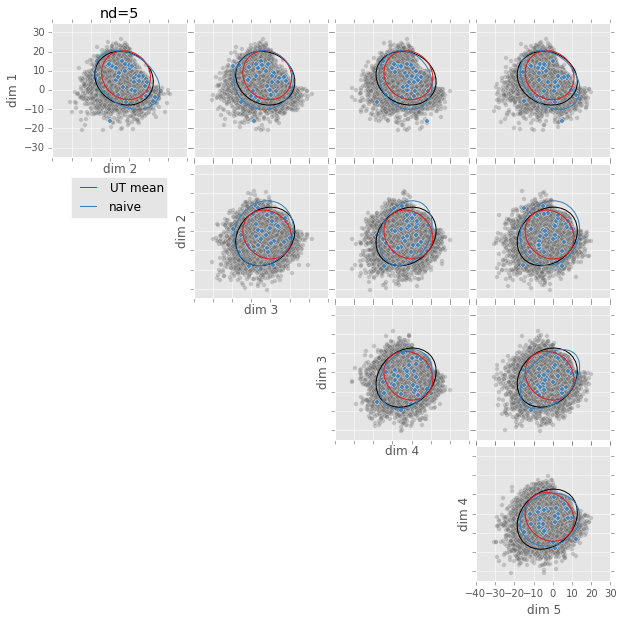

In [38]:
ndi = 1

bam.nd = nds[ndi]
dynfun = lambda x: x + dt * bam.dynfun(x)

means, covs, Samples = naiveSamplingEstimate(Z[ndi], C[ndi], dynfun, Nsamples[ndi, 1])

print "W = %6.4f" % (WassDist(meantruedyn[ndi], covtruedyn[ndi], means, covs),)

meanEst = np.c_[meanUTdyn[ndi][:, uti], means]
covEst = np.concatenate((covUTdyn[ndi][:, :, uti][:, :, None], covs[:, :, None]), axis=2)
estlabels = [utlabels[uti], 'naive']

axes = aux.plotHDSamples(Struedyn[ndi], meantruedyn[ndi], covtruedyn[ndi], 
                  title=ndlabels[ndi], meanUT=meanEst, 
                  covUT=covEst, utlabels=estlabels, S2=Samples)

So sampling appears to outperform the UT in high dimensions in the sense that for `nd=11` you need fewer random samples than the number of sigma points to, on average, better approximate the transformed mean and covariance. In few dimensions, however, you need considerably more random samples to reliably achieve the accuracy of the UT. This result is caused by a relative drop in accuracy of the UT in higher dimensions (cf. underestimation of variance).

Altogether, the above results demonstrate that, compared to naive sampling, I do not gain as much computational efficiency as I thought from the UT. Instead of saving orders of magnitude of computation time I am, perhaps, only up to 5-times faster with the UT than with naive sampling (in low dimensions). In some circumstances naive sampling actually produces more accurate approximations of nonlinearly transformed mean and covariance with fewer numbers of samples than the UT. My results also suggest that, when I want to achieve consistently lower distances, i.e., better accuracy, than with UT I can use naive sampling with about 50 samples (for up to 11 dimensions tested here). This number, however, only applies to the difficult situation in which the source distribution is very wide and covers several complicated nonlinear regions of the transform function, i.e., where the UT approximation is not perfectly accurate. At this point it is also worth remembering that the accuracy, as quantified by the Wasserstein distance between Gaussians, may not be the accuracy you may be interested in, because it ignores higher-order moments of the distributions.

#### Gaussianity assumptions

The Gauss set explicitly captures one of the fourth moments of Gaussian distributions. At the same time, it often produces the lowest divergences in the situations tested above, at least when the dimensionality is low. So, does the theory work? Does the advantage of the Gauss set come from capturing some fourth moments of the source distribution $p({\bf r})$? So far I have only used Gaussian $p({\bf r})$. I will, therefore, investigate two things:

1. Does the Gauss set perform best when its free parameter is set to $\kappa=3$?
2. Will the Gauss set loose its advantage when $p({\bf r})$ becomes non-Gaussian?

I will run the experiments in two dimensions again, because the Gauss set performs particularly well there (and particularly badly in higher dimensions). The results from above already suggest that 1. will not hold in all conditions, but let me look at this more diligently.

__Benefits of $\kappa=3$.__ In two dimensions the Gauss set is equal to the mean set and because I find the interpretation of $w_0$ more intuitive, I will use the mean set for the experiments. As a reminder: For $w_0=0$ I recover the base set and for $w_0=1/3$ I recover the Gauss set. This means that, when I vary $w_0\in [0,1)$, the performance should be best for $w_0=1/3$, if capturing 4th moments of the source distribution $p({\bf r})$ helps in approximating the mean and covariance of the transformed distribution $p({\bf o})$. The following experiment tests this assumption:

test point: stable fixed point


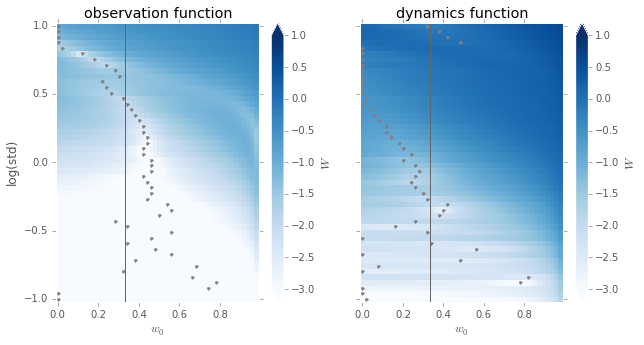

In [39]:
# set dimensionality
nd = 2
bam.nd = nd
dynfun = lambda x: x + dt * bam.dynfun(x)
ut_mean.D = nd

# select test point (0: 5*ones, 1: saddle, 2: stable FP)
testp = 2
print 'test point: ' + pointlabels[testp]
if testp == 0:
    Z = 5.0 * np.ones(nd)
elif testp == 1:
    Z = bam.findSaddle()
else:
    Z = np.r_[bam.hopg, np.zeros(nd-1)]

# select values of w0 to test
W0 = np.linspace(0, 1, 51)
W0 = W0[:-1]
nut = W0.size    

# select stds to test
stds = np.logspace(-1, 1, 50)
num = stds.size

Dis = np.zeros((num, nut, 2))
for stdi, std in enumerate(stds):
    # set spread of source distribution
    C = std**2 * np.eye(nd)

    # estimate true transformed mean and cov
    meantrue = np.zeros((nd, 2))
    covtrue = np.zeros((nd, nd, 2))
    Strue = np.zeros((bam.nd, nsample, 2))
    meantrue[:, 0], covtrue[:, :, 0], Strue[:, :, 0] = \
        naiveSamplingEstimate(Z, C, bam.obsfun, nsample)
    meantrue[:, 1], covtrue[:, :, 1], Strue[:, :, 1] = \
        naiveSamplingEstimate(Z, C, dynfun, nsample)

    for w0i, w0 in enumerate(W0):
        ut_mean.w0 = w0
        meanUT, covUT = ut_mean.performUT(Z, C, bam.obsfun)
        Dis[stdi, w0i, 0] = WassDist(meantrue[:, 0], covtrue[:, :, 0], meanUT, covUT)
        
        meanUT, covUT = ut_mean.performUT(Z, C, dynfun)
        Dis[stdi, w0i, 1] = WassDist(meantrue[:, 1], covtrue[:, :, 1], meanUT, covUT)
        
ax = aux.plotKLcontours(W0, np.log10(stds), Dis, titles=funlabels)

The generated figure shows the Wasserstein distance $W$ depending on $w_0$ (x-axis) and on the spread of the source distribution (`std` in log10-scale on the y-axis) for the observation (left) and the dynamics (right) functions. I have marked $w_0=1/3$ by a vertical, grey line. Lighter blues indicate lower distance (in log10-scale), but I have limited the color scaling such that $W\leq 0.001$ is white and $W\geq 10$ is the darkest blue. The light gray dots indicate for each tested spread (`std`) the $w_0$ with the lowest $W$.

The figure shows that the UT with mean set reaches distances around and below 0.001 for a wide range of values of $w_0$ if the spread of the source distribution is low (`std`$<0.4\approx 10^{-0.4}$). In other words, for tight source distributions the UT with mean set performs very well irrespective of the precise setting of $w_0$. For medium spread of the source distribution (`0.4 < std < 3`) it appears that the distances are indeed lowest for $w_0 \approx 1/3$, although the best values of $w_0$ seem to be slightly shifted from 1/3. The following plot confirms this for `std` $\approx 1$:

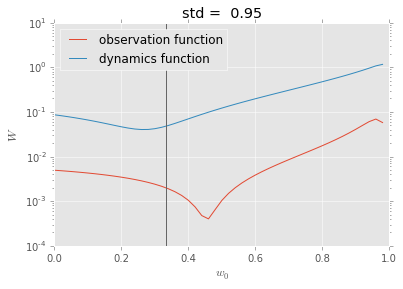

In [40]:
std = 10 ** 0.0
stdi = np.abs(std - stds).argmin()
ax = plt.axes()
ax.plot(W0, Dis[stdi, :, :])
ax.set(yscale='log', title='std = %5.2f' % (stds[stdi],), 
       xlabel='$w_0$', ylabel='$W$')
ax.legend(funlabels, loc='upper left');
ax.plot(np.ones(2)/3, ax.get_ylim(), color='0.4');

For both, the observation and dynamics function, the divergence has a minimum at $w_0$ that is close to but unequal from 1/3 (tested with the stable fixed point at `std=0.95`). I would, however, still say that the performance for $w_0=0$ is good with $W\leq 0.07$ such that the qualitative difference in performance between the found minima and other (small) values of $w_0$ is small. It is, therefore, more interesting to check the dependence of performance on $w_0$ in situations where the distances are higher overall. This is the case for larger spreads of the source distribution. For example, for `std=6.25`, the stable fixed point and the dynamics function $W\approx 1.0$ at $w_0=1/3$, but the minimum is at $w_0=0$ with $W\approx 0.6$ (check by setting `std = 10 ** 0.8` in the code above). The blue-colored contour plot above also shows that $w_0=0$ should be preferred over $w_0=1/3$ for the dynamics function and intermediate `std`s, because this value leads to lower distances. This relationship, however, reverses for large spreads above `std=7`. Then, $w_0\geq 1/3$ should be preferred for the dynamics function. For large spreads of the source distribution the distances for the observation function show exactly the opposite trend: there, $w_0\rightarrow 0$ produces the smallest distances. With some variation I observed similar effects for all three test points.

The results for large spreads of the source distribution worry me, because they suggest contradictory consequences for setting $w_0$ depending on the nonlinear transform function. This fact demonstrates that simply capturing some moments of the source distribution with the sigma points is not sufficient to optimise the accuracy of the UT approximation. Instead, the specific form of the transform function, which enters the Taylor series of mean and covariance in the form of partial derivatives, also matters to a large degree. There is, however, a different interpretation of these results that is compatible with the original idea of the UT: It could be argued that a wider source distribution increases the contribution of higher order terms in the Taylor series, because a large region of the transform function is used to compute the transformed mean and covariance. This means in turn that the wider the source distribution the less important it becomes to capture the 4th moments relative to capturing higher moments. So the performance differences that I observe for different values of $w_0$ and different transform functions may simply reflect the different higher order partial derivatives of the transform functions. Optimal values of $w_0\neq 1/3$ may in this interpretation just imply that the resulting sigma points by accident better capture relevant higher moments.

So how should I set $w_0$, if I don't know much about my transform function, but do know that I will have large spread in my source distributions? My observations suggest that $w_0\approx 1/3$ may be a good compromise. I can actually quantify that by determining the $w_0$ that leads to the lowest sum of $W$ (will be stongly influenced by large values) or the lowest median $W$ over the two transform functions and all values of `std`: 

In [41]:
Dispool = Dis.transpose((0, 2, 1)).reshape((2 * num, nut))
print 'best w0 (median): %4.2f' % (W0[np.median(Dispool, axis=0).argmin()], )
print 'best w0 (sum): %4.2f' % (W0[np.sum(Dispool, axis=0).argmin()], )

best w0 (median): 0.36
best w0 (sum): 0.04


Because I chose `std` logarithmically there are many more low values than the large values that I'm interested in, but I can look at values above a certain `std` too:

In [42]:
inds = stds > 3.0
ninds = inds.sum()
Dispool = Dis[inds, :, :].transpose((0, 2, 1)).reshape((2 * ninds, nut))
print 'best w0 (median): %4.2f' % (W0[np.median(Dispool, axis=0).argmin()], )
print 'best w0 (sum): %4.2f' % (W0[np.sum(Dispool, axis=0).argmin()], )

best w0 (median): 0.00
best w0 (sum): 0.00


These values of $w_0$ are specific to the chosen test point, but they don't differ that much for the other test points such that $0\leq w_0 \leq 1/3$ appears to be a sensible range with a tendency towards lower values for large spreads of the source distribution.

__Non-Gaussian distributions.__ The above results suggest that at least for some spreads of the source distribution the Gauss set indeed performs close to optimally, but is this really because the Gauss set captures some 4th moments of the underlying Gaussian distribution? I can test this by contrasting a Gaussian source distribution and a non-Gaussian source distribution with the same mean and covariance. The Gauss set should produce better approximations of the transformed distribution for the Gaussian source distribution. 

I will use the dynamics function at the saddle point for this experiment, because the resulting transformed distributions are non-Gaussian even for intermediate spreads of the source distribution and the means of source and transformed distributions should be the same. Consequently, I can use the distributions resulting from transforming a Gaussian through the dynamics function as non-Gaussian source distributions for my experiment. As a reminder, here is the non-Gaussian distribution for `std=0.5` of the original Gaussian source distribution (also check out other values):

test point: saddle point
std =  0.50
covariance of transformed distribution:
[[ 0.27310566 -0.24311549]
 [-0.24311549  0.27328973]]


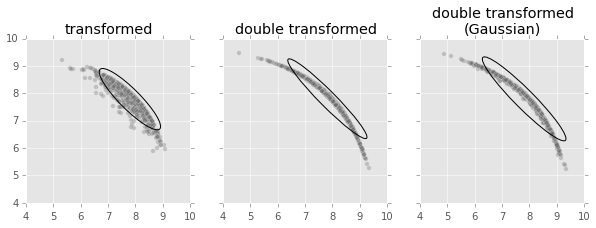

In [43]:
# select test point (0: 5*ones, 1: saddle, 2: stable FP)
testp = 1
print 'test point: ' + pointlabels[testp]
if testp == 0:
    Z = 5.0 * np.ones(nd)
elif testp == 1:
    Z = bam.findSaddle()
else:
    Z = np.r_[bam.hopg, np.zeros(nd-1)]

# spread of source distribution
std = 0.5
C = std**2 * np.eye(nd)
print 'std = %5.2f' % (std, )

# get non-Gaussian by transforming through dynamics function
meantrue = np.zeros((nd, 3))
covtrue = np.zeros((nd, nd, 3))
Strue = np.zeros((nd, nsample, 3))
meantrue[:, 0], covtrue[:, :, 0], Strue[:, :, 0] = \
    naiveSamplingEstimate(Z, C, dynfun, nsample)

# transform again to see how non-Gaussian distribution changes
meantrue[:, 1], covtrue[:, :, 1], Strue[:, :, 1] = \
    naiveSamplingEstimate(Strue[:, :, 0], None, dynfun)
    
# transform Gaussian with mean and cov of transformed distribution
meantrue[:, 2], covtrue[:, :, 2], Strue[:, :, 2] = \
    naiveSamplingEstimate(meantrue[:, 0], covtrue[:, :, 0], dynfun, nsample)

# plot everything
aux.plotSamples(Strue, meantrue, covtrue,
                titles=['transformed', 'double transformed', 
                        'double transformed\n(Gaussian)'], ylabels=[''])
print 'covariance of transformed distribution:'
print covtrue[:, :, 0]

Additionally to the transformed distribution I also show the distribution resulting from transforming the transformed distribution which I call the double transformed distribution. This distributions looks less noisy, because the dynamics function concentrates points on a trajectory between the stable fixed points and the saddle point (see also the slope field plot for the dynamics function above). Whereas the double transformed distribution is stretched more than the transformed distribution for `std=0.5`, for large spreads, e.g., `std=10`, the double transformed distribution is more condensed. This is because the dynamics function implements a pull towards the stable fixed points which spreads points out that are close to the saddle point, but contracts points that are beyond the stable fixed points. Further, I show in the third panel the distribution resulting from transforming a Gaussian with the same mean and covariance as the transformed distribution. This distribution is strikingly similar to the true double transformed distribution. It just appears to be slightly more spread out. Even for other spreads of the source distribution the true and Gaussian double transformed distributions are very similar. I guess, what you can learn from this is that the mean and covariance are usually already good descriptors of the true distributions. This further means that I cannot expect large differences in the performance of the UT when I compare the UT against naive sampling with Gaussian and non-Gaussian source distributions.

I will now generate non-Gaussian source distributions with increasing spreads. These non-Gaussian distributions will have very different covariances from the Gaussian source distributions that I used before, because the two state variables are anti-correlated such that the covariance is better represented by an elongated ellipse instead of a circle. Also, the variances will be lower than those previously tested. For example, a Gaussian with `std=8` transforms to a distribution with a standard deviation of indiviudal variables of about 5.9. To reach standard deviations of 10 I, thus, use `std` up to 16 for the initial Gaussian.

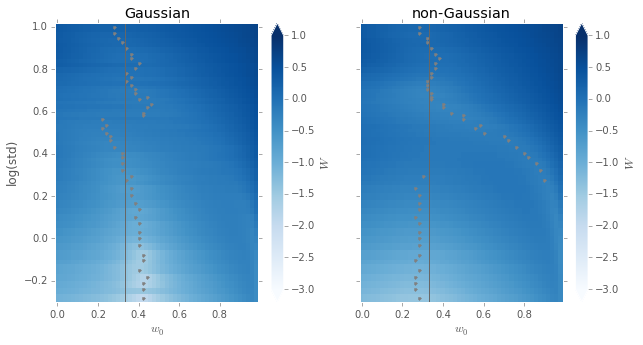

In [44]:
# select stds to test
stds = np.logspace(np.log10(0.5), np.log10(16), 50)
num = stds.size

# dimensions: stds, w0, dist
stdstr = np.zeros(num)
Dis = np.zeros((num, nut, 2))
for stdi, std in enumerate(stds):
    # set spread of initial source distribution
    C = std**2 * np.eye(nd)

    # get non-Gaussian source distribution
    meantrue = np.zeros((nd, 2))
    covtrue = np.zeros((nd, nd, 2))
    Strue = np.zeros((nd, nsample, 2))
    mean0, cov0, S0 = naiveSamplingEstimate(Z, C, dynfun, nsample)
    
    stdstr[stdi] = np.sqrt(cov0[0, 0])
    
    # transform by assuming Gaussian source with corresponding mean and cov
    meantrue[:, 0], covtrue[:, :, 0], Strue[:, :, 0] = \
        naiveSamplingEstimate(mean0, cov0, dynfun, nsample)
    
    # transform true non-Gaussian distribution
    meantrue[:, 1], covtrue[:, :, 1], Strue[:, :, 1] = \
        naiveSamplingEstimate(S0, None, dynfun)

    for w0i, w0 in enumerate(W0):
        # use UT to approximate double transformed distribution
        ut_mean.w0 = w0
        meanUT, covUT = ut_mean.performUT(mean0, cov0, dynfun)
        
        # compute KL for Gaussian source
        Dis[stdi, w0i, 0] = WassDist(meantrue[:, 0], covtrue[:, :, 0], meanUT, covUT)
        
        # compute KL for non-Gaussian source with same mean and cov
        Dis[stdi, w0i, 1] = WassDist(meantrue[:, 1], covtrue[:, :, 1], meanUT, covUT)

ax = aux.plotKLcontours(W0, np.log10(stdstr), Dis, titles=['Gaussian', 'non-Gaussian'])

The first to note from these plots is that they show less variation in color, i.e., Wasserstein distances, than the previous contour plots. This is mainly because the lowest distance achieved here is $W = \approx 10^{-1.8}$ whereas above it was $W\approx 10^{-3}$. 

Overall, the shades of blue are similar between the Gaussian and non-Gaussian source distributions, but for intermediate spreads (`2 < std < 4`) it indeed appears that $w_0=1/3$ gives higher accuracy for the Gaussian distribution, although it's rarely exactly $w_0=1/3$ that gives the lowest distance. For small and large spreads $w_0=1/3$ appears to be a reasonable compromise for both Gaussian and non-Gaussian source distributions.

In conclusion, there is something about $w_0\approx 1/3$ that ensures reasonably good UT approximations when compared to other settings of $w_0$. It may, therefore, well be that capturing some 4th moments improves the UT approximation, but I cannot draw definite conclusions from these results, because they only rely on a single transform function. Also, I should mention that, for example, at the point $[5, 5]^T$ larger values of $w_0\approx 0.5$ give lowest distances for a wide range of source distribution spreads, no matter whether Gaussian or non-Gaussian source distributions are transformed. Note that this finding contrasts to my results above where I found that $w_0$ should best be small, perhaps around $w_0=0.2$, across all test points. The difference to the results here is that the source distribution here has no isometric covariance anymore, but is already aligned to the principle domain of the transform function. In light of the new variation in the best values for $w_0$ depending on the source distribution and the transform function $w_0=1/3$ may be a good compromise after all, although the particular type of transform function may have a larger influence on that than the Gaussianity of the source distribution.